# Importing required packages


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import requests
import datetime
import pandas_datareader as pdr
import warnings
warnings.simplefilter("ignore")
import joblib
import imblearn

from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import *
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost import XGBClassifier
pd.set_option('display.max_columns', 100)

# DATA EXTRACTION

## FRED API

In [ ]:
api_key = 'f5a62fb8d6f35ef47c60bffda8c53ba4'
# Unique key from the FRED website.

In [ ]:
# class that will interact with the FRED API

class FredPy:

    def __init__(self, token=None):
        self.token = token
        self.url = "https://api.stlouisfed.org/fred/series/observations" + \
                    "?series_id={seriesID}&api_key={key}&file_type=json" + \
                    "&observation_start={start}&units={units}&frequency={frequency}"

    def set_token(self, token):
        self.token = token


    def get_series(self, seriesID, start, units, frequency):

        # The URL string with the values inserted into it
        url_formatted = self.url.format(
            seriesID=seriesID, start=start, units=units, frequency=frequency, key=self.token
        )

        response = requests.get(url_formatted)

        if(self.token):
            # If the response was successful, extract the data from it
            if(response.status_code == 200):
                data = pd.DataFrame(response.json()['observations'])[['date', 'value']]\
                        .assign(date = lambda cols: pd.to_datetime(cols['date']))\
                        .assign(value = lambda cols: cols['value'].astype(float))\
                        .rename(columns = {'value': seriesID})

                return data

            else:
                raise Exception("Bad response from API, status code = {}".format(response.status_code))
        else:
            raise Exception("You did not specify an API key.")

In [ ]:
# Instantiate fredpy object
fredpy = FredPy()

# Set the API key
fredpy.set_token(api_key)

## Direct Data

In [ ]:
# Getting the House Price index as a target variable.
HPI_target = fredpy.get_series(
    seriesID = 'CSUSHPISA', 
    start = '2002-01-01', 
    units = '',
    frequency = 'm'
)

# Getting the Consumer price index as a feature to get an inflation measure.
CPI_index = fredpy.get_series(
    seriesID = 'CPIAUCSL', 
    start = '2002-01-01', 
    units = '',
    frequency= 'm'
)

# Employment to population ratio to check whether the changes in Employment
# affects the House price index.
Employment_rate = fredpy.get_series(
    seriesID = 'EMRATIO', 
    start = '2002-01-01', 
    units = '',
    frequency='m'
)

# Unemployment rate to check whether the changes in Employment
# affects the House price index.
Unemployment_rate = fredpy.get_series(
    seriesID = 'UNRATE', 
    start = '2002-01-01', 
    units = '',
    frequency='m'
)


# Mortgage_15 = fredpy.get_series(
#     seriesID = 'MORTGAGE15US', 
#     start = '2002-01-01', 
#     units = '',
#     frequency='m'
# )

# # getting 30-Year Fixed Rate Mortgage Average in the United States.
# Mortgage_30 = fredpy.get_series(
#     seriesID = 'MORTGAGE30US', 
#     start = '2002-01-01', 
#     units = 'lin',
#     frequency='m'
# )

# Producer Price Index by Commodity: Lumber and Wood Products that directly affect the House price index.
lumber_price_index = fredpy.get_series(
    seriesID = 'WPU08', 
    start = '2002-01-01', 
    units = 'lin',
    frequency='m'
)

# Getting Median sales price of new houses in US.
Median_Sales_price_new = fredpy.get_series(
    seriesID = 'MSPNHSUS', 
    start = '2002-01-01', 
    units = 'lin',
    frequency='m'
)

# To see how the increase in population affects the House price index.
Population = fredpy.get_series(
    seriesID = 'POPTHM', 
    start = '2002-01-01', 
    units = 'lin',
    frequency='m'
)

# To see how the increase Zillow house value index affects the House price index.
Zillow_House_value_index = fredpy.get_series(
    seriesID = 'USAUCSFRCONDOSMSAMID', 
    start = '2002-01-01', 
    units = 'lin',
    frequency='m'
)

In [ ]:
df1 = pd.read_csv('/content/MORTGAGE15US.csv')

In [ ]:
df1


,DATE,MORTGAGE15US_PCH
0,1991-10-01,-2.16263
1,1991-11-01,-1.84497
2,1991-12-01,-3.07471
3,1992-01-01,-0.79306
4,1992-02-01,4.70272
...,...,...
366,2022-04-01,24.33628
367,2022-05-01,5.21945
368,2022-06-01,4.89290
369,2022-07-01,-0.84910


In [ ]:
Mortgage_15yr = df1.iloc[-248:-1]
Mortgage_15yr['DATE'] = Mortgage_15yr['DATE'].apply(pd.to_datetime)
Mortgage_15yr.rename(columns = {'DATE':'date'},inplace = True)
Mortgage_15yr.reset_index(inplace = True)
Mortgage_15yr['MORTGAGE15US_PCH'] = Mortgage_15yr['MORTGAGE15US_PCH'].astype(float)
Mortgage_15yr.drop('index',axis = 1, inplace = True) 

In [ ]:
Mortgage_15yr.dtypes

date                datetime64[ns]
MORTGAGE15US_PCH           float64
dtype: object

getting 15-Year Fixed Rate Mortgage Average in the United States.

In [ ]:
df2 = pd.read_csv('/content/MORTGAGE30US.csv')

In [ ]:
df2

,DATE,MORTGAGE30US
0,2002-01-01,6.9975
1,2002-02-01,6.8925
2,2002-03-01,7.0140
3,2002-04-01,6.9850
4,2002-05-01,6.8060
...,...,...
242,2022-03-01,4.1720
243,2022-04-01,4.9825
244,2022-05-01,5.2300
245,2022-06-01,5.5220


In [ ]:
Mortgage_30yr = df2.iloc[:-2]
Mortgage_30yr.rename(columns = {'DATE':'date'},inplace = True)
Mortgage_30yr['date'] = Mortgage_15yr['date'].apply(pd.to_datetime)

In [ ]:
Mortgage_30yr.dtypes

date            datetime64[ns]
MORTGAGE30US           float64
dtype: object

In [ ]:
df = pd.merge(HPI_target,CPI_index,on=['date'])
df = pd.merge(HPI_target,CPI_index,on=['date'])
df = pd.merge(df,Employment_rate,on=['date'])
df = pd.merge(df,Mortgage_15yr,on=['date'])
df = pd.merge(df,Mortgage_30yr,on=['date'])
df = pd.merge(df,Unemployment_rate,on=['date'])
df = pd.merge(df,lumber_price_index,on=['date'])
df = pd.merge(df,Median_Sales_price_new,on=['date'])
df = pd.merge(df,Population,on=['date'])
df = pd.merge(df,Zillow_House_value_index,on=['date'])

In [ ]:
df

,date,CSUSHPISA,CPIAUCSL,EMRATIO,MORTGAGE15US_PCH,MORTGAGE30US,UNRATE,WPU08,MSPNHSUS,POPTHM,USAUCSFRCONDOSMSAMID
0,2002-01-01,117.143,177.700,62.7,-0.95529,6.9975,5.7,171.700,187100.0,286739.0,146655.0
1,2002-02-01,117.844,178.000,63.0,-1.62037,6.8925,5.7,173.000,191100.0,286935.0,147359.0
2,2002-03-01,118.687,178.500,62.8,2.21176,7.0140,5.7,175.300,183400.0,287131.0,148101.0
3,2002-04-01,119.611,179.300,62.7,-0.62922,6.9850,5.9,175.600,187100.0,287343.0,148887.0
4,2002-05-01,120.724,179.500,62.9,-3.01158,6.8060,5.8,174.400,181000.0,287571.0,149724.0
...,...,...,...,...,...,...,...,...,...,...,...
240,2022-01-01,284.767,281.933,59.7,13.28790,3.4450,4.0,349.222,430500.0,332684.0,328848.0
241,2022-02-01,290.371,284.182,59.9,12.68797,3.7625,3.8,359.934,427400.0,332750.0,334078.0
242,2022-03-01,296.496,287.708,60.1,13.09425,4.1720,3.6,372.661,435900.0,332812.0,339362.0
243,2022-04-01,301.704,288.663,60.0,24.33628,4.9825,3.6,356.479,457000.0,332863.0,344931.0


## Series Data

The below function are used to get a series of data from FRED.

In [ ]:
def transform_series_response(response):
  latest_date = list(response.json()['meta']['data'].keys())[0]
  return pd.DataFrame(response.json()['meta']['data'][latest_date])

  
def get_fred_series_data(api_key,
                         series):
  # url
  url = "https://api.stlouisfed.org/geofred/series/data?series_id={0}&api_key={1}&file_type=json".format(series, api_key)
  # response
  response = requests.request("GET", url)
  return response

  
def get_fred_data(param_list, start_date, end_date):
  df = pdr.DataReader(param_list, 'fred', start_date, end_date)
  return df.reset_index()

In [ ]:
seriesID_Housing_permits = 'CABPPRIVSA'

Reason we're choosing new house permits is to get an overall picture of the demand side and how it impacts the HPI.

In [ ]:
# get all series ids per series
response = get_fred_series_data(api_key, seriesID_Housing_permits)
# transform response into a dataframe
df_all_series_ids = transform_series_response(response)
df_all_series_ids.head()

,region,code,value,series_id
0,District of Columbia,11,709.000000,DCBPPRIVSA
1,Maryland,24,1781.599201,MDBPPRIVSA
2,Arizona,04,5035.497568,AZBPPRIVSA
3,Minnesota,27,2905.400311,MNBPPRIVSA
4,West Virginia,54,316.083204,WVBPPRIVSA


In [ ]:
# get all series to a list
series_list = df_all_series_ids['series_id'].tolist()
print('Length of series list:', len(series_list) + 1)
series_list[:5] # shows first five in list

Length of series list: 52


['DCBPPRIVSA', 'MDBPPRIVSA', 'AZBPPRIVSA', 'MNBPPRIVSA', 'WVBPPRIVSA']

In [ ]:
# set range for time
start_date = '2002-01-01'
end_date = ''
# get series data
df_permits_all_series = get_fred_data(param_list=series_list, # all series to get data for
                                      start_date=start_date, # start date
                                      end_date=end_date) # get latest date
df_permits_all_series.head()

,DATE,DCBPPRIVSA,MDBPPRIVSA,AZBPPRIVSA,MNBPPRIVSA,WVBPPRIVSA,RIBPPRIVSA,OHBPPRIVSA,ALBPPRIVSA,KYBPPRIVSA,TNBPPRIVSA,NDBPPRIVSA,NMBPPRIVSA,WABPPRIVSA,AKBPPRIVSA,NHBPPRIVSA,NCBPPRIVSA,VABPPRIVSA,ARBPPRIVSA,MEBPPRIVSA,NJBPPRIVSA,NVBPPRIVSA,OKBPPRIVSA,MTBPPRIVSA,WYBPPRIVSA,CABPPRIVSA,LABPPRIVSA,COBPPRIVSA,DEBPPRIVSA,NEBPPRIVSA,WIBPPRIVSA,ORBPPRIVSA,MSBPPRIVSA,SCBPPRIVSA,CTBPPRIVSA,MIBPPRIVSA,INBPPRIVSA,IDBPPRIVSA,PABPPRIVSA,VTBPPRIVSA,TXBPPRIVSA,NYBPPRIVSA,FLBPPRIVSA,MOBPPRIVSA,GABPPRIVSA,ILBPPRIVSA,KSBPPRIVSA,UTBPPRIVSA,MABPPRIVSA,SDBPPRIVSA,IABPPRIVSA,HIBPPRIVSA
0,2002-01-01,49.0,2682.697061,4841.644406,3433.710411,362.698833,287.070950,4618.890733,1860.016428,1743.235385,2615.228283,289.358049,459.118817,3019.760690,329.953938,662.526357,6401.358634,4671.748585,1694.973662,560.582376,2487.185987,3053.961249,1203.854698,298.681489,131.296026,11799.729247,1377.582050,4006.520247,544.419097,923.727587,2885.034419,1914.410876,821.018937,2601.387257,711.370349,4158.212893,3925.543997,1004.088708,3528.240538,279.014008,12938.185279,4162.759751,16015.519741,2192.577081,7439.984624,4943.557816,891.528072,1569.356225,1480.366336,200.236970,1322.197300,328.462385
1,2002-02-01,2.0,2400.509509,4776.170943,3241.190347,379.758048,217.338632,4443.931027,1828.154358,1704.743891,3348.145279,344.754527,1113.389611,2905.700600,241.926660,875.455707,7127.574889,4548.114680,841.462260,605.991453,2517.354635,2543.392373,1142.637226,209.427982,179.130416,12748.122155,1424.441440,3343.654774,481.823025,669.502883,3207.434758,1893.962304,1400.035503,2863.617484,917.605926,4096.282965,3181.111345,849.976413,3755.752873,197.052036,12428.374377,4705.786780,16438.423637,2204.877344,8134.451353,4690.907026,833.956013,1507.331802,1556.168720,743.531932,1648.497574,317.802116
2,2002-03-01,3.0,2450.427287,4468.430839,2805.040295,280.812015,207.857471,3904.571351,1749.196766,1409.610674,2350.149190,224.679720,1316.118308,3116.801760,459.333068,579.149970,6078.744524,5260.213324,689.327032,607.787352,1921.909023,2644.421609,876.720516,346.779074,144.038005,11622.665975,1440.814719,3692.170805,524.341161,747.428887,2704.102143,1668.389958,755.524489,2532.895873,792.117066,4093.060483,2976.928691,829.834644,2886.534726,338.132527,13128.501597,3194.644046,14316.202356,1730.847770,8079.977020,4599.201132,901.364234,1471.448424,1340.964964,254.862271,974.615053,237.834181
3,2002-04-01,27.0,2482.346114,5240.978179,3088.171491,331.326971,192.596894,4346.319081,1962.341804,1689.395727,2798.766282,220.815767,884.287348,3447.295221,136.612440,627.968884,6961.957400,4480.565287,954.202520,545.712780,2406.232573,2421.252649,1018.412342,282.039131,181.204370,12554.272430,1332.942670,4619.471293,525.100311,842.332642,3128.822111,2006.377403,792.479363,3011.637254,1008.768482,4032.838169,3429.748675,1058.884462,3320.139354,246.511008,13214.345726,3962.402971,14198.085418,1886.250934,8410.230803,5151.946743,909.092973,1500.123290,1330.285119,377.363365,1093.612941,516.502621
4,2002-05-01,53.0,2284.314833,5357.959766,2822.419368,333.290322,213.467785,4391.109185,2251.357445,1587.808136,2912.123179,304.639319,929.404065,3698.097962,197.769465,593.166124,6432.190625,4899.681947,827.280252,541.463002,2521.125084,3042.872050,1071.573579,292.579628,178.022818,11997.695675,1565.424284,4265.022245,507.526187,752.569612,3311.356224,2049.814632,878.282536,2708.791266,836.764932,4212.748410,3242.468616,973.802344,3462.420177,211.170406,13439.199259,4586.293324,13132.980705,2236.879029,8603.410319,4763.774489,940.427906,1729.569045,1822.498261,337.265208,1143.048683,705.518244


In [ ]:
df_permits_all_series

,DATE,DCBPPRIVSA,MDBPPRIVSA,AZBPPRIVSA,MNBPPRIVSA,WVBPPRIVSA,RIBPPRIVSA,OHBPPRIVSA,ALBPPRIVSA,KYBPPRIVSA,TNBPPRIVSA,NDBPPRIVSA,NMBPPRIVSA,WABPPRIVSA,AKBPPRIVSA,NHBPPRIVSA,NCBPPRIVSA,VABPPRIVSA,ARBPPRIVSA,MEBPPRIVSA,NJBPPRIVSA,NVBPPRIVSA,OKBPPRIVSA,MTBPPRIVSA,WYBPPRIVSA,CABPPRIVSA,LABPPRIVSA,COBPPRIVSA,DEBPPRIVSA,NEBPPRIVSA,WIBPPRIVSA,ORBPPRIVSA,MSBPPRIVSA,SCBPPRIVSA,CTBPPRIVSA,MIBPPRIVSA,INBPPRIVSA,IDBPPRIVSA,PABPPRIVSA,VTBPPRIVSA,TXBPPRIVSA,NYBPPRIVSA,FLBPPRIVSA,MOBPPRIVSA,GABPPRIVSA,ILBPPRIVSA,KSBPPRIVSA,UTBPPRIVSA,MABPPRIVSA,SDBPPRIVSA,IABPPRIVSA,HIBPPRIVSA
0,2002-01-01,49.0,2682.697061,4841.644406,3433.710411,362.698833,287.070950,4618.890733,1860.016428,1743.235385,2615.228283,289.358049,459.118817,3019.760690,329.953938,662.526357,6401.358634,4671.748585,1694.973662,560.582376,2487.185987,3053.961249,1203.854698,298.681489,131.296026,11799.729247,1377.582050,4006.520247,544.419097,923.727587,2885.034419,1914.410876,821.018937,2601.387257,711.370349,4158.212893,3925.543997,1004.088708,3528.240538,279.014008,12938.185279,4162.759751,16015.519741,2192.577081,7439.984624,4943.557816,891.528072,1569.356225,1480.366336,200.236970,1322.197300,328.462385
1,2002-02-01,2.0,2400.509509,4776.170943,3241.190347,379.758048,217.338632,4443.931027,1828.154358,1704.743891,3348.145279,344.754527,1113.389611,2905.700600,241.926660,875.455707,7127.574889,4548.114680,841.462260,605.991453,2517.354635,2543.392373,1142.637226,209.427982,179.130416,12748.122155,1424.441440,3343.654774,481.823025,669.502883,3207.434758,1893.962304,1400.035503,2863.617484,917.605926,4096.282965,3181.111345,849.976413,3755.752873,197.052036,12428.374377,4705.786780,16438.423637,2204.877344,8134.451353,4690.907026,833.956013,1507.331802,1556.168720,743.531932,1648.497574,317.802116
2,2002-03-01,3.0,2450.427287,4468.430839,2805.040295,280.812015,207.857471,3904.571351,1749.196766,1409.610674,2350.149190,224.679720,1316.118308,3116.801760,459.333068,579.149970,6078.744524,5260.213324,689.327032,607.787352,1921.909023,2644.421609,876.720516,346.779074,144.038005,11622.665975,1440.814719,3692.170805,524.341161,747.428887,2704.102143,1668.389958,755.524489,2532.895873,792.117066,4093.060483,2976.928691,829.834644,2886.534726,338.132527,13128.501597,3194.644046,14316.202356,1730.847770,8079.977020,4599.201132,901.364234,1471.448424,1340.964964,254.862271,974.615053,237.834181
3,2002-04-01,27.0,2482.346114,5240.978179,3088.171491,331.326971,192.596894,4346.319081,1962.341804,1689.395727,2798.766282,220.815767,884.287348,3447.295221,136.612440,627.968884,6961.957400,4480.565287,954.202520,545.712780,2406.232573,2421.252649,1018.412342,282.039131,181.204370,12554.272430,1332.942670,4619.471293,525.100311,842.332642,3128.822111,2006.377403,792.479363,3011.637254,1008.768482,4032.838169,3429.748675,1058.884462,3320.139354,246.511008,13214.345726,3962.402971,14198.085418,1886.250934,8410.230803,5151.946743,909.092973,1500.123290,1330.285119,377.363365,1093.612941,516.502621
4,2002-05-01,53.0,2284.314833,5357.959766,2822.419368,333.290322,213.467785,4391.109185,2251.357445,1587.808136,2912.123179,304.639319,929.404065,3698.097962,197.769465,593.166124,6432.190625,4899.681947,827.280252,541.463002,2521.125084,3042.872050,1071.573579,292.579628,178.022818,11997.695675,1565.424284,4265.022245,507.526187,752.569612,3311.356224,2049.814632,878.282536,2708.791266,836.764932,4212.748410,3242.468616,973.802344,3462.420177,211.170406,13439.199259,4586.293324,13132.980705,2236.879029,8603.410319,4763.774489,940.427906,1729.569045,1822.498261,337.265208,1143.048683,705.518244
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241,2022-02-01,350.0,1832.343368,5701.660168,3322.194688,345.971499,115.618102,2381.024684,1758.064848,1101.849510,4801.021434,269.776757,473.273080,4625.557786,150.549570,381.617624,8236.161455,3083.660526,1

In [ ]:
df_permits_all_series 

,DATE,DCBPPRIVSA,MDBPPRIVSA,AZBPPRIVSA,MNBPPRIVSA,WVBPPRIVSA,RIBPPRIVSA,OHBPPRIVSA,ALBPPRIVSA,KYBPPRIVSA,TNBPPRIVSA,NDBPPRIVSA,NMBPPRIVSA,WABPPRIVSA,AKBPPRIVSA,NHBPPRIVSA,NCBPPRIVSA,VABPPRIVSA,ARBPPRIVSA,MEBPPRIVSA,NJBPPRIVSA,NVBPPRIVSA,OKBPPRIVSA,MTBPPRIVSA,WYBPPRIVSA,CABPPRIVSA,LABPPRIVSA,COBPPRIVSA,DEBPPRIVSA,NEBPPRIVSA,WIBPPRIVSA,ORBPPRIVSA,MSBPPRIVSA,SCBPPRIVSA,CTBPPRIVSA,MIBPPRIVSA,INBPPRIVSA,IDBPPRIVSA,PABPPRIVSA,VTBPPRIVSA,TXBPPRIVSA,NYBPPRIVSA,FLBPPRIVSA,MOBPPRIVSA,GABPPRIVSA,ILBPPRIVSA,KSBPPRIVSA,UTBPPRIVSA,MABPPRIVSA,SDBPPRIVSA,IABPPRIVSA,HIBPPRIVSA
0,2002-01-01,49.0,2682.697061,4841.644406,3433.710411,362.698833,287.070950,4618.890733,1860.016428,1743.235385,2615.228283,289.358049,459.118817,3019.760690,329.953938,662.526357,6401.358634,4671.748585,1694.973662,560.582376,2487.185987,3053.961249,1203.854698,298.681489,131.296026,11799.729247,1377.582050,4006.520247,544.419097,923.727587,2885.034419,1914.410876,821.018937,2601.387257,711.370349,4158.212893,3925.543997,1004.088708,3528.240538,279.014008,12938.185279,4162.759751,16015.519741,2192.577081,7439.984624,4943.557816,891.528072,1569.356225,1480.366336,200.236970,1322.197300,328.462385
1,2002-02-01,2.0,2400.509509,4776.170943,3241.190347,379.758048,217.338632,4443.931027,1828.154358,1704.743891,3348.145279,344.754527,1113.389611,2905.700600,241.926660,875.455707,7127.574889,4548.114680,841.462260,605.991453,2517.354635,2543.392373,1142.637226,209.427982,179.130416,12748.122155,1424.441440,3343.654774,481.823025,669.502883,3207.434758,1893.962304,1400.035503,2863.617484,917.605926,4096.282965,3181.111345,849.976413,3755.752873,197.052036,12428.374377,4705.786780,16438.423637,2204.877344,8134.451353,4690.907026,833.956013,1507.331802,1556.168720,743.531932,1648.497574,317.802116
2,2002-03-01,3.0,2450.427287,4468.430839,2805.040295,280.812015,207.857471,3904.571351,1749.196766,1409.610674,2350.149190,224.679720,1316.118308,3116.801760,459.333068,579.149970,6078.744524,5260.213324,689.327032,607.787352,1921.909023,2644.421609,876.720516,346.779074,144.038005,11622.665975,1440.814719,3692.170805,524.341161,747.428887,2704.102143,1668.389958,755.524489,2532.895873,792.117066,4093.060483,2976.928691,829.834644,2886.534726,338.132527,13128.501597,3194.644046,14316.202356,1730.847770,8079.977020,4599.201132,901.364234,1471.448424,1340.964964,254.862271,974.615053,237.834181
3,2002-04-01,27.0,2482.346114,5240.978179,3088.171491,331.326971,192.596894,4346.319081,1962.341804,1689.395727,2798.766282,220.815767,884.287348,3447.295221,136.612440,627.968884,6961.957400,4480.565287,954.202520,545.712780,2406.232573,2421.252649,1018.412342,282.039131,181.204370,12554.272430,1332.942670,4619.471293,525.100311,842.332642,3128.822111,2006.377403,792.479363,3011.637254,1008.768482,4032.838169,3429.748675,1058.884462,3320.139354,246.511008,13214.345726,3962.402971,14198.085418,1886.250934,8410.230803,5151.946743,909.092973,1500.123290,1330.285119,377.363365,1093.612941,516.502621
4,2002-05-01,53.0,2284.314833,5357.959766,2822.419368,333.290322,213.467785,4391.109185,2251.357445,1587.808136,2912.123179,304.639319,929.404065,3698.097962,197.769465,593.166124,6432.190625,4899.681947,827.280252,541.463002,2521.125084,3042.872050,1071.573579,292.579628,178.022818,11997.695675,1565.424284,4265.022245,507.526187,752.569612,3311.356224,2049.814632,878.282536,2708.791266,836.764932,4212.748410,3242.468616,973.802344,3462.420177,211.170406,13439.199259,4586.293324,13132.980705,2236.879029,8603.410319,4763.774489,940.427906,1729.569045,1822.498261,337.265208,1143.048683,705.518244
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241,2022-02-01,350.0,1832.343368,5701.660168,3322.194688,345.971499,115.618102,2381.024684,1758.064848,1101.849510,4801.021434,269.776757,473.273080,4625.557786,150.549570,381.617624,8236.161455,3083.660526,1

In [ ]:
df_permits_all_series['Total_Permits'] = df_permits_all_series.iloc[:, -51:-1].sum(axis =1)

In [ ]:
df_permits_all_series.head(5)

,DATE,DCBPPRIVSA,MDBPPRIVSA,AZBPPRIVSA,MNBPPRIVSA,WVBPPRIVSA,RIBPPRIVSA,OHBPPRIVSA,ALBPPRIVSA,KYBPPRIVSA,TNBPPRIVSA,NDBPPRIVSA,NMBPPRIVSA,WABPPRIVSA,AKBPPRIVSA,NHBPPRIVSA,NCBPPRIVSA,VABPPRIVSA,ARBPPRIVSA,MEBPPRIVSA,NJBPPRIVSA,NVBPPRIVSA,OKBPPRIVSA,MTBPPRIVSA,WYBPPRIVSA,CABPPRIVSA,LABPPRIVSA,COBPPRIVSA,DEBPPRIVSA,NEBPPRIVSA,WIBPPRIVSA,ORBPPRIVSA,MSBPPRIVSA,SCBPPRIVSA,CTBPPRIVSA,MIBPPRIVSA,INBPPRIVSA,IDBPPRIVSA,PABPPRIVSA,VTBPPRIVSA,TXBPPRIVSA,NYBPPRIVSA,FLBPPRIVSA,MOBPPRIVSA,GABPPRIVSA,ILBPPRIVSA,KSBPPRIVSA,UTBPPRIVSA,MABPPRIVSA,SDBPPRIVSA,IABPPRIVSA,HIBPPRIVSA,Total_Permits
0,2002-01-01,49.0,2682.697061,4841.644406,3433.710411,362.698833,287.070950,4618.890733,1860.016428,1743.235385,2615.228283,289.358049,459.118817,3019.760690,329.953938,662.526357,6401.358634,4671.748585,1694.973662,560.582376,2487.185987,3053.961249,1203.854698,298.681489,131.296026,11799.729247,1377.582050,4006.520247,544.419097,923.727587,2885.034419,1914.410876,821.018937,2601.387257,711.370349,4158.212893,3925.543997,1004.088708,3528.240538,279.014008,12938.185279,4162.759751,16015.519741,2192.577081,7439.984624,4943.557816,891.528072,1569.356225,1480.366336,200.236970,1322.197300,328.462385,141395.122454
1,2002-02-01,2.0,2400.509509,4776.170943,3241.190347,379.758048,217.338632,4443.931027,1828.154358,1704.743891,3348.145279,344.754527,1113.389611,2905.700600,241.926660,875.455707,7127.574889,4548.114680,841.462260,605.991453,2517.354635,2543.392373,1142.637226,209.427982,179.130416,12748.122155,1424.441440,3343.654774,481.823025,669.502883,3207.434758,1893.962304,1400.035503,2863.617484,917.605926,4096.282965,3181.111345,849.976413,3755.752873,197.052036,12428.374377,4705.786780,16438.423637,2204.877344,8134.451353,4690.907026,833.956013,1507.331802,1556.168720,743.531932,1648.497574,317.802116,143460.937494
2,2002-03-01,3.0,2450.427287,4468.430839,2805.040295,280.812015,207.857471,3904.571351,1749.196766,1409.610674,2350.149190,224.679720,1316.118308,3116.801760,459.333068,579.149970,6078.744524,5260.213324,689.327032,607.787352,1921.909023,2644.421609,876.720516,346.779074,144.038005,11622.665975,1440.814719,3692.170805,524.341161,747.428887,2704.102143,1668.389958,755.524489,2532.895873,792.117066,4093.060483,2976.928691,829.834644,2886.534726,338.132527,13128.501597,3194.644046,14316.202356,1730.847770,8079.977020,4599.201132,901.364234,1471.448424,1340.964964,254.862271,974.615053,237.834181,131492.690186
3,2002-04-01,27.0,2482.346114,5240.978179,3088.171491,331.326971,192.596894,4346.319081,1962.341804,1689.395727,2798.766282,220.815767,884.287348,3447.295221,136.612440,627.968884,6961.957400,4480.565287,954.202520,545.712780,2406.232573,2421.252649,1018.412342,282.039131,181.204370,12554.272430,1332.942670,4619.471293,525.100311,842.332642,3128.822111,2006.377403,792.479363,3011.637254,1008.768482,4032.838169,3429.748675,1058.884462,3320.139354,246.511008,13214.345726,3962.402971,14198.085418,1886.250934,8410.230803,5151.946743,909.092973,1500.123290,1330.285119,377.363365,1093.612941,516.502621,140671.867165
4,2002-05-01,53.0,2284.314833,5357.959766,2822.419368,333.290322,213.467785,4391.109185,2251.357445,1587.808136,2912.123179,304.639319,929.404065,3698.097962,197.769465,593.166124,6432.190625,4899.681947,827.280252,541.463002,2521.125084,3042.872050,1071.573579,292.579628,178.022818,11997.695675,1565.424284,4265.022245,507.526187,752.569612,3311.356224,2049.814632,878.282536,2708.791266,836.764932,4212.748410,3242.468616,973.802344,3462.420177,211.170406,13439.199259,4586.293324,13132.980705,2236.879029,8603.410319,4763.774489,940.427906,1729.569045,1822.498261,337.265208,1143.048683,705.518244,141447.919715


In [ ]:
df_permits_all_series.drop(df_permits_all_series.columns[1:52], axis=1, inplace=True)


In [ ]:
df_permits_all_series.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 246 entries, 0 to 245
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   DATE           246 non-null    datetime64[ns]
 1   Total_Permits  246 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 4.0 KB


## Data Preprocessing

In [ ]:
# renaming the date column to merge.
df_permits_all_series.columns = df_permits_all_series.columns.str.replace('DATE', 'date')

In [ ]:
# Merging two dataframes to get final dataframe.
df = pd.merge(df,df_permits_all_series,on=['date'])


In [ ]:
# renaming all the columns for better understanding.
df.rename(columns = {'CSUSHPISA':'HPI', 'CPIAUCSL':'CPI','EMRATIO':'Employment_ratio','UNRATE':'Unemployment_rate',
                     'WPU08':'Lumber_price_index','MSPNHSUS':'Median_Sales_price','POPTHM':'Population',
                     'MORTGAGE15US_PCH':'Mortgage_15yr','MORTGAGE30US':'Mortgage_30yr','USAUCSFRCONDOSMSAMID':'Zillow_HVI'}, inplace = True)

In [ ]:
df

,date,HPI,CPI,Employment_ratio,Mortgage_15yr,Mortgage_30yr,Unemployment_rate,Lumber_price_index,Median_Sales_price,Population,Zillow_HVI,Total_Permits
0,2002-01-01,117.143,177.700,62.7,-0.95529,6.9975,5.7,171.700,187100.0,286739.0,146655.0,141395.122454
1,2002-02-01,117.844,178.000,63.0,-1.62037,6.8925,5.7,173.000,191100.0,286935.0,147359.0,143460.937494
2,2002-03-01,118.687,178.500,62.8,2.21176,7.0140,5.7,175.300,183400.0,287131.0,148101.0,131492.690186
3,2002-04-01,119.611,179.300,62.7,-0.62922,6.9850,5.9,175.600,187100.0,287343.0,148887.0,140671.867165
4,2002-05-01,120.724,179.500,62.9,-3.01158,6.8060,5.8,174.400,181000.0,287571.0,149724.0,141447.919715
...,...,...,...,...,...,...,...,...,...,...,...,...
240,2022-01-01,284.767,281.933,59.7,13.28790,3.4450,4.0,349.222,430500.0,332684.0,328848.0,145334.443500
241,2022-02-01,290.371,284.182,59.9,12.68797,3.7625,3.8,359.934,427400.0,332750.0,334078.0,151150.800354
242,2022-03-01,296.496,287.708,60.1,13.09425,4.1720,3.6,372.661,435900.0,332812.0,339362.0,157715.508361
243,2022-04-01,301.704,288.663,60.0,24.33628,4.9825,3.6,356.479,457000.0,332863.0,344931.0,147879.096876


In [ ]:
# DATES FEATURES
def date_features(df):
    # Date Features
    df['date'] = pd.to_datetime(df['date'])
    df['year'] = df.date.dt.year
    df['month'] = df.date.dt.month
    
    # Drop date
    # df.drop('date', axis=1, inplace=True)
    
    return df

# Dates Features for Train, Test
df = date_features(df)

In [ ]:
df

,date,HPI,CPI,Employment_ratio,Mortgage_15yr,Mortgage_30yr,Unemployment_rate,Lumber_price_index,Median_Sales_price,Population,Zillow_HVI,Total_Permits,year,month
0,2002-01-01,117.143,177.700,62.7,-0.95529,6.9975,5.7,171.700,187100.0,286739.0,146655.0,141395.122454,2002,1
1,2002-02-01,117.844,178.000,63.0,-1.62037,6.8925,5.7,173.000,191100.0,286935.0,147359.0,143460.937494,2002,2
2,2002-03-01,118.687,178.500,62.8,2.21176,7.0140,5.7,175.300,183400.0,287131.0,148101.0,131492.690186,2002,3
3,2002-04-01,119.611,179.300,62.7,-0.62922,6.9850,5.9,175.600,187100.0,287343.0,148887.0,140671.867165,2002,4
4,2002-05-01,120.724,179.500,62.9,-3.01158,6.8060,5.8,174.400,181000.0,287571.0,149724.0,141447.919715,2002,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
240,2022-01-01,284.767,281.933,59.7,13.28790,3.4450,4.0,349.222,430500.0,332684.0,328848.0,145334.443500,2022,1
241,2022-02-01,290.371,284.182,59.9,12.68797,3.7625,3.8,359.934,427400.0,332750.0,334078.0,151150.800354,2022,2
242,2022-03-01,296.496,287.708,60.1,13.09425,4.1720,3.6,372.661,435900.0,332812.0,339362.0,157715.508361,2022,3
243,2022-04-01,301.704,288.663,60.0,24.33628,4.9825,3.6,356.479,457000.0,332863.0,344931.0,147879.096876,2022,4


In [ ]:
df.set_index('date',inplace = True)

In [ ]:
df

,HPI,CPI,Employment_ratio,Mortgage_15yr,Mortgage_30yr,Unemployment_rate,Lumber_price_index,Median_Sales_price,Population,Zillow_HVI,Total_Permits,year,month
date,,,,,,,,,,,,,
2002-01-01,117.143,177.700,62.7,-0.95529,6.9975,5.7,171.700,187100.0,286739.0,146655.0,141395.122454,2002,1
2002-02-01,117.844,178.000,63.0,-1.62037,6.8925,5.7,173.000,191100.0,286935.0,147359.0,143460.937494,2002,2
2002-03-01,118.687,178.500,62.8,2.21176,7.0140,5.7,175.300,183400.0,287131.0,148101.0,131492.690186,2002,3
2002-04-01,119.611,179.300,62.7,-0.62922,6.9850,5.9,175.600,187100.0,287343.0,148887.0,140671.867165,2002,4
2002-05-01,120.724,179.500,62.9,-3.01158,6.8060,5.8,174.400,181000.0,287571.0,149724.0,141447.919715,2002,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-01,284.767,281.933,59.7,13.28790,3.4450,4.0,349.222,430500.0,332684.0,328848.0,145334.443500,2022,1
2022-02-01,290.371,284.182,59.9,12.68797,3.7625,3.8,359.934,427400.0,332750.0,334078.0,151150.800354,2022,2
2022-03-01,296.496,287.708,60.1,13.09425,4.1720,3.6,372.661,435900.0,332812.0,339362.0,157715.508361,2022,3


In [ ]:
df['month'].value_counts()

1     21
2     21
3     21
4     21
5     21
6     20
7     20
8     20
9     20
10    20
11    20
12    20
Name: month, dtype: int64

In [ ]:
df['year'].value_counts()

2002    12
2013    12
2021    12
2020    12
2019    12
2018    12
2017    12
2016    12
2015    12
2014    12
2012    12
2003    12
2011    12
2010    12
2009    12
2008    12
2007    12
2006    12
2005    12
2004    12
2022     5
Name: year, dtype: int64

Dataframe have been created, Let's explore the data and clean the data.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 245 entries, 2002-01-01 to 2022-05-01
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   HPI                 245 non-null    float64
 1   CPI                 245 non-null    float64
 2   Employment_ratio    245 non-null    float64
 3   Mortgage_15yr       245 non-null    float64
 4   Mortgage_30yr       245 non-null    float64
 5   Unemployment_rate   245 non-null    float64
 6   Lumber_price_index  245 non-null    float64
 7   Median_Sales_price  245 non-null    float64
 8   Population          245 non-null    float64
 9   Zillow_HVI          245 non-null    float64
 10  Total_Permits       245 non-null    float64
 11  year                245 non-null    int64  
 12  month               245 non-null    int64  
dtypes: float64(11), int64(2)
memory usage: 26.8 KB


Added Year and month and using date as index are for future scope of using time-series forecasting. 

# EDA

## Cleaning

From the Dataframe we can say that none of the columns are categorical columns.


In [ ]:
df.isnull().value_counts()

HPI    CPI    Employment_ratio  Mortgage_15yr  Mortgage_30yr  Unemployment_rate  Lumber_price_index  Median_Sales_price  Population  Zillow_HVI  Total_Permits  year   month
False  False  False             False          False          False              False               False               False       False       False          False  False    245
dtype: int64

No Null value is detected

let's look for outliers.

## Univariate analysis 

In [ ]:
def univariate(df,col,hue =None):    
    sns.set(style="darkgrid")
    fig, ax=plt.subplots(nrows =2,ncols=1,figsize=(20,30))
    ax[0].set_title("Distribution Plot")
    sns.distplot(df[col],ax=ax[0])
    ax[1].set_title("Box Plot")
    sns.boxplot(data =df, x=col,ax=ax[1],orient='v')
    plt.show()

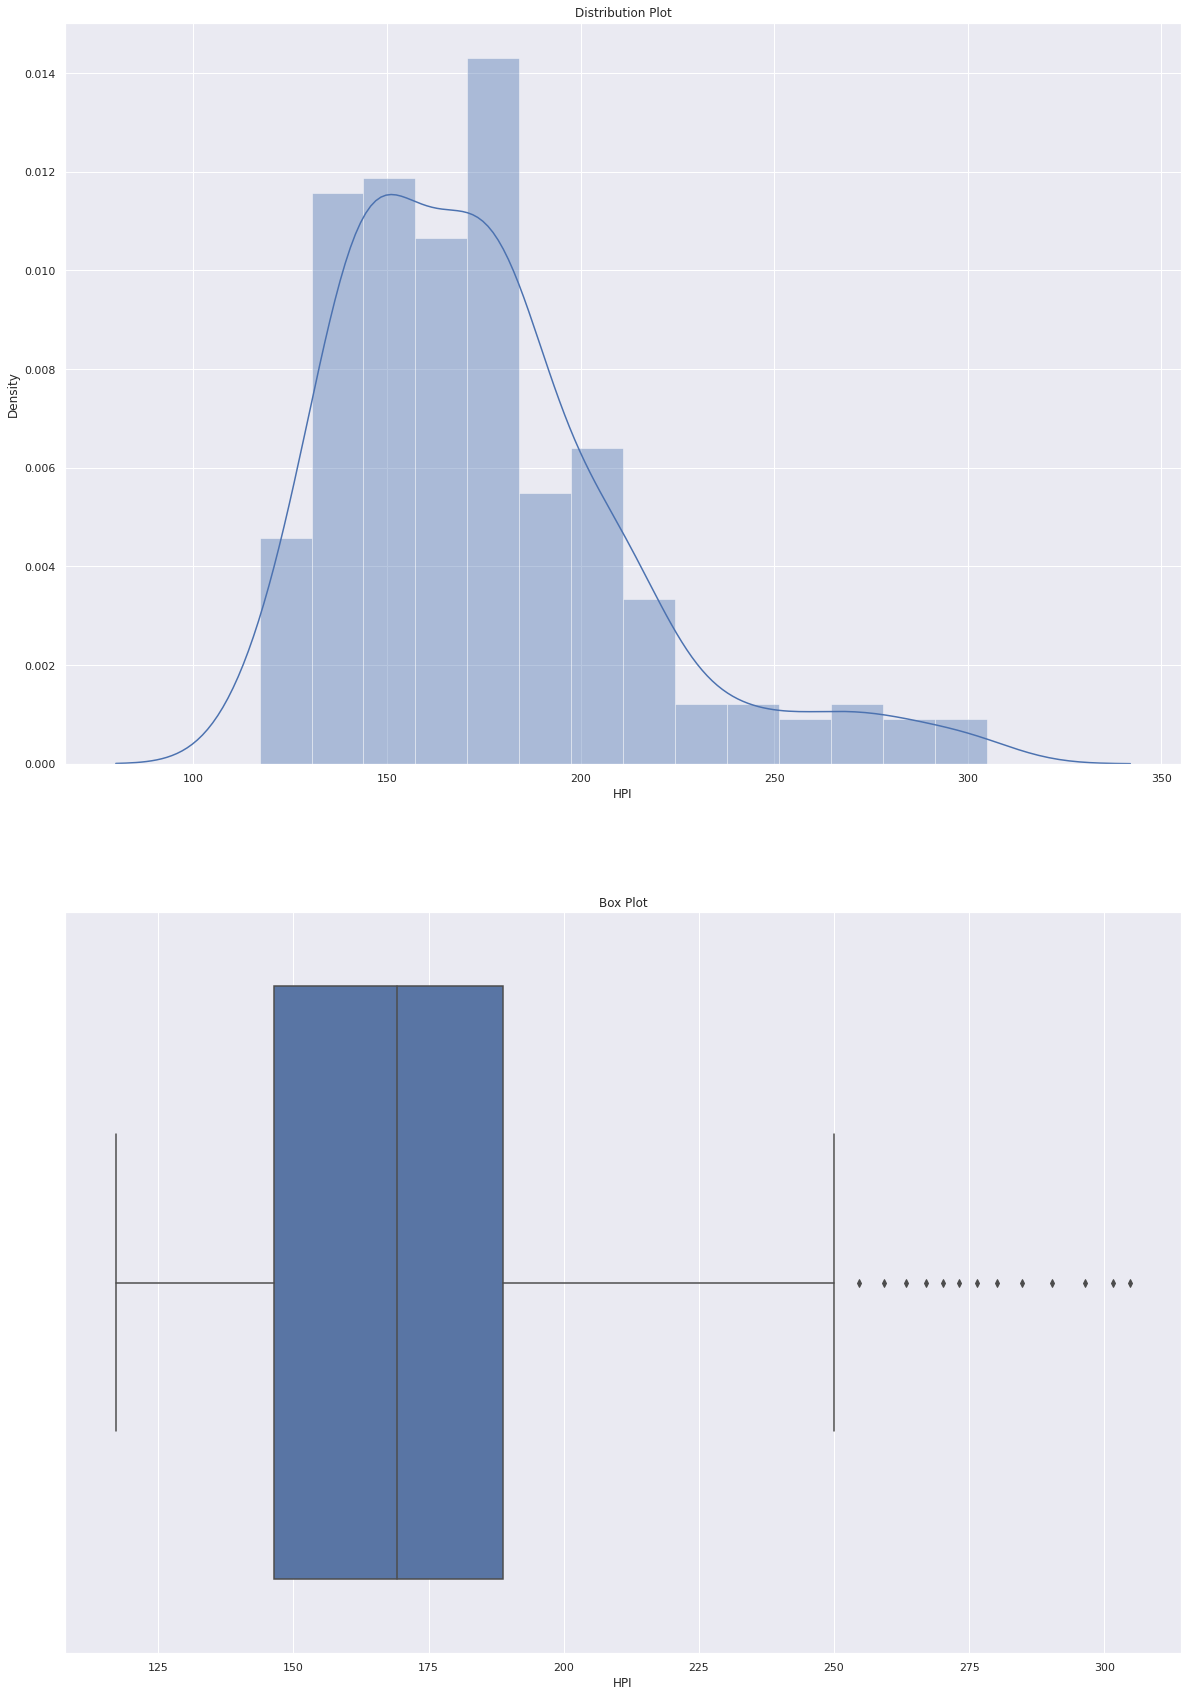

In [ ]:
univariate(df = df, col = 'HPI')

From the above plots,


1.  HPI is in binomial distribution.
2.  Have some outliers but with HPI it is neglible since its a live data.



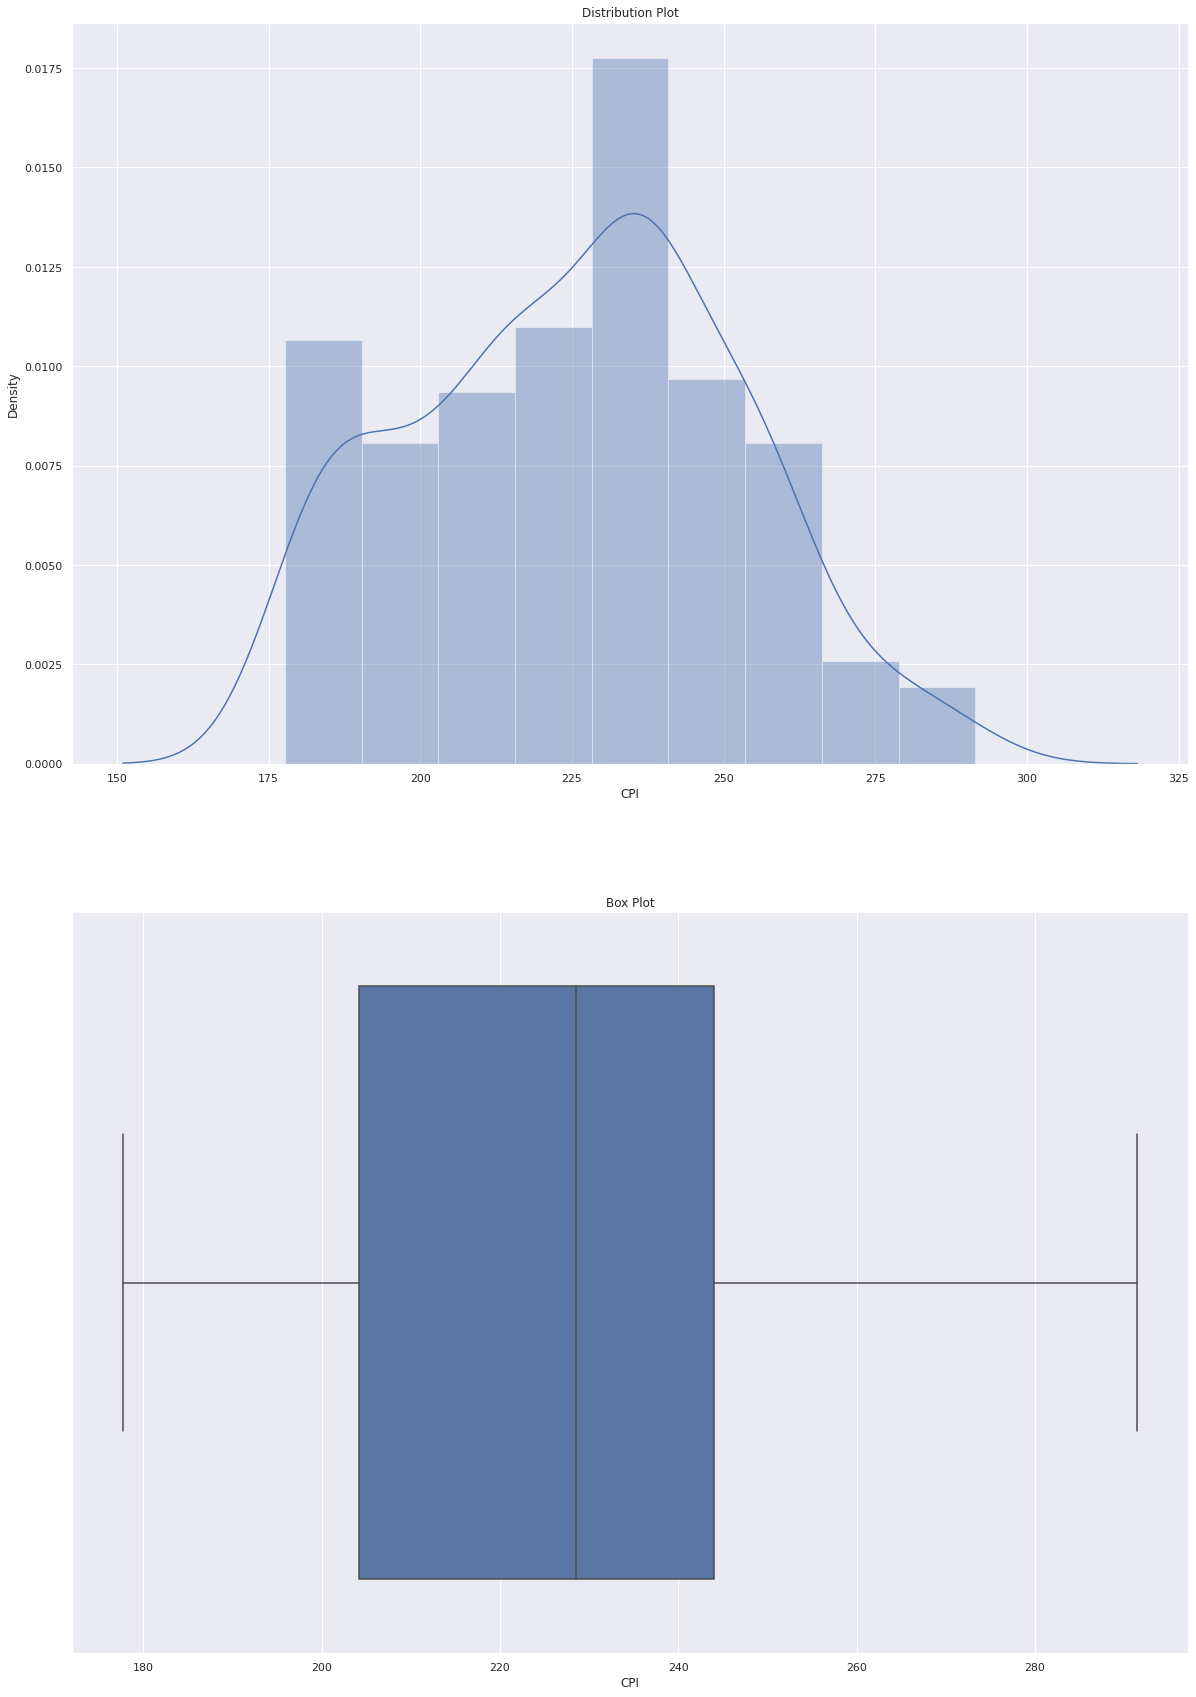

In [ ]:
univariate(df = df, col = 'CPI')

From the above plots,


1.   CPI also follows normal distribution
2.   There are no outliers.



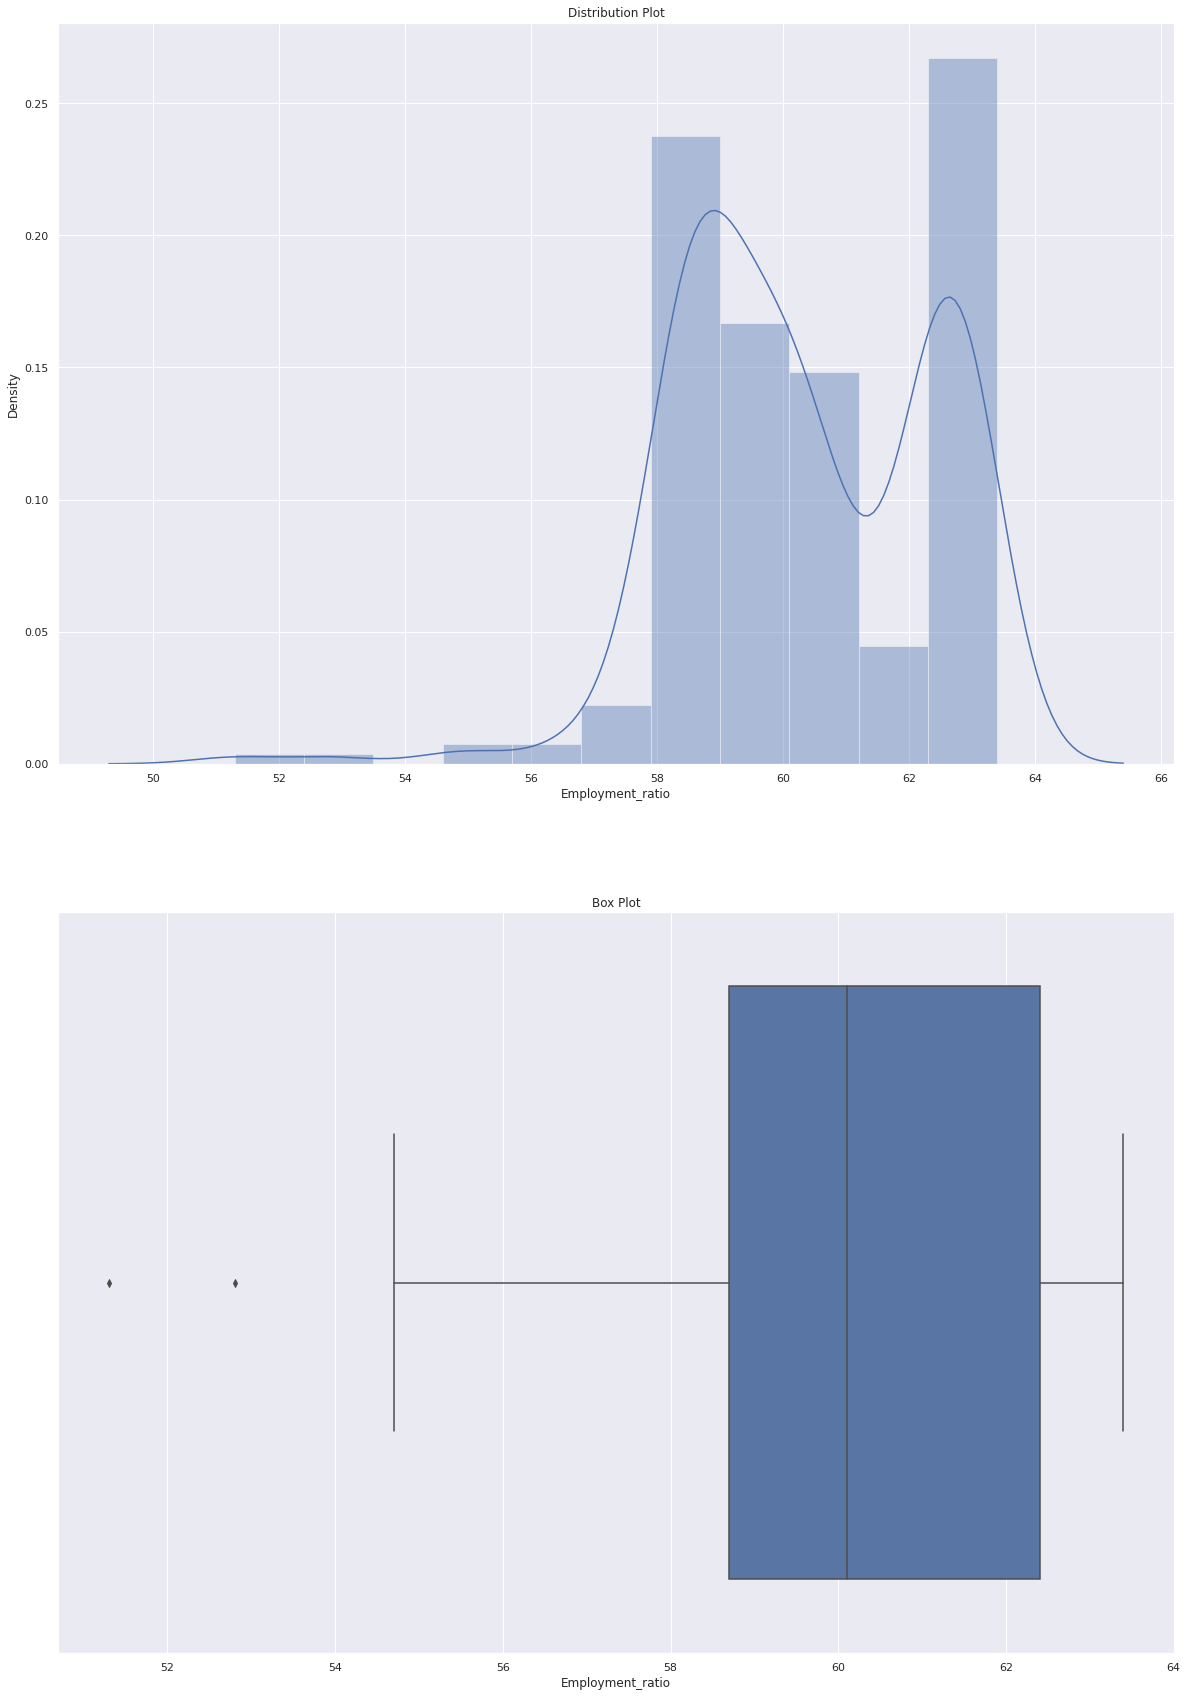

In [ ]:
univariate(df = df, col = 'Employment_ratio')

From the above charts,


1. Employment_ratio varies between 50 and 66 
2. There are couple of outliers in the lower end since this is a live value we can ignore it.



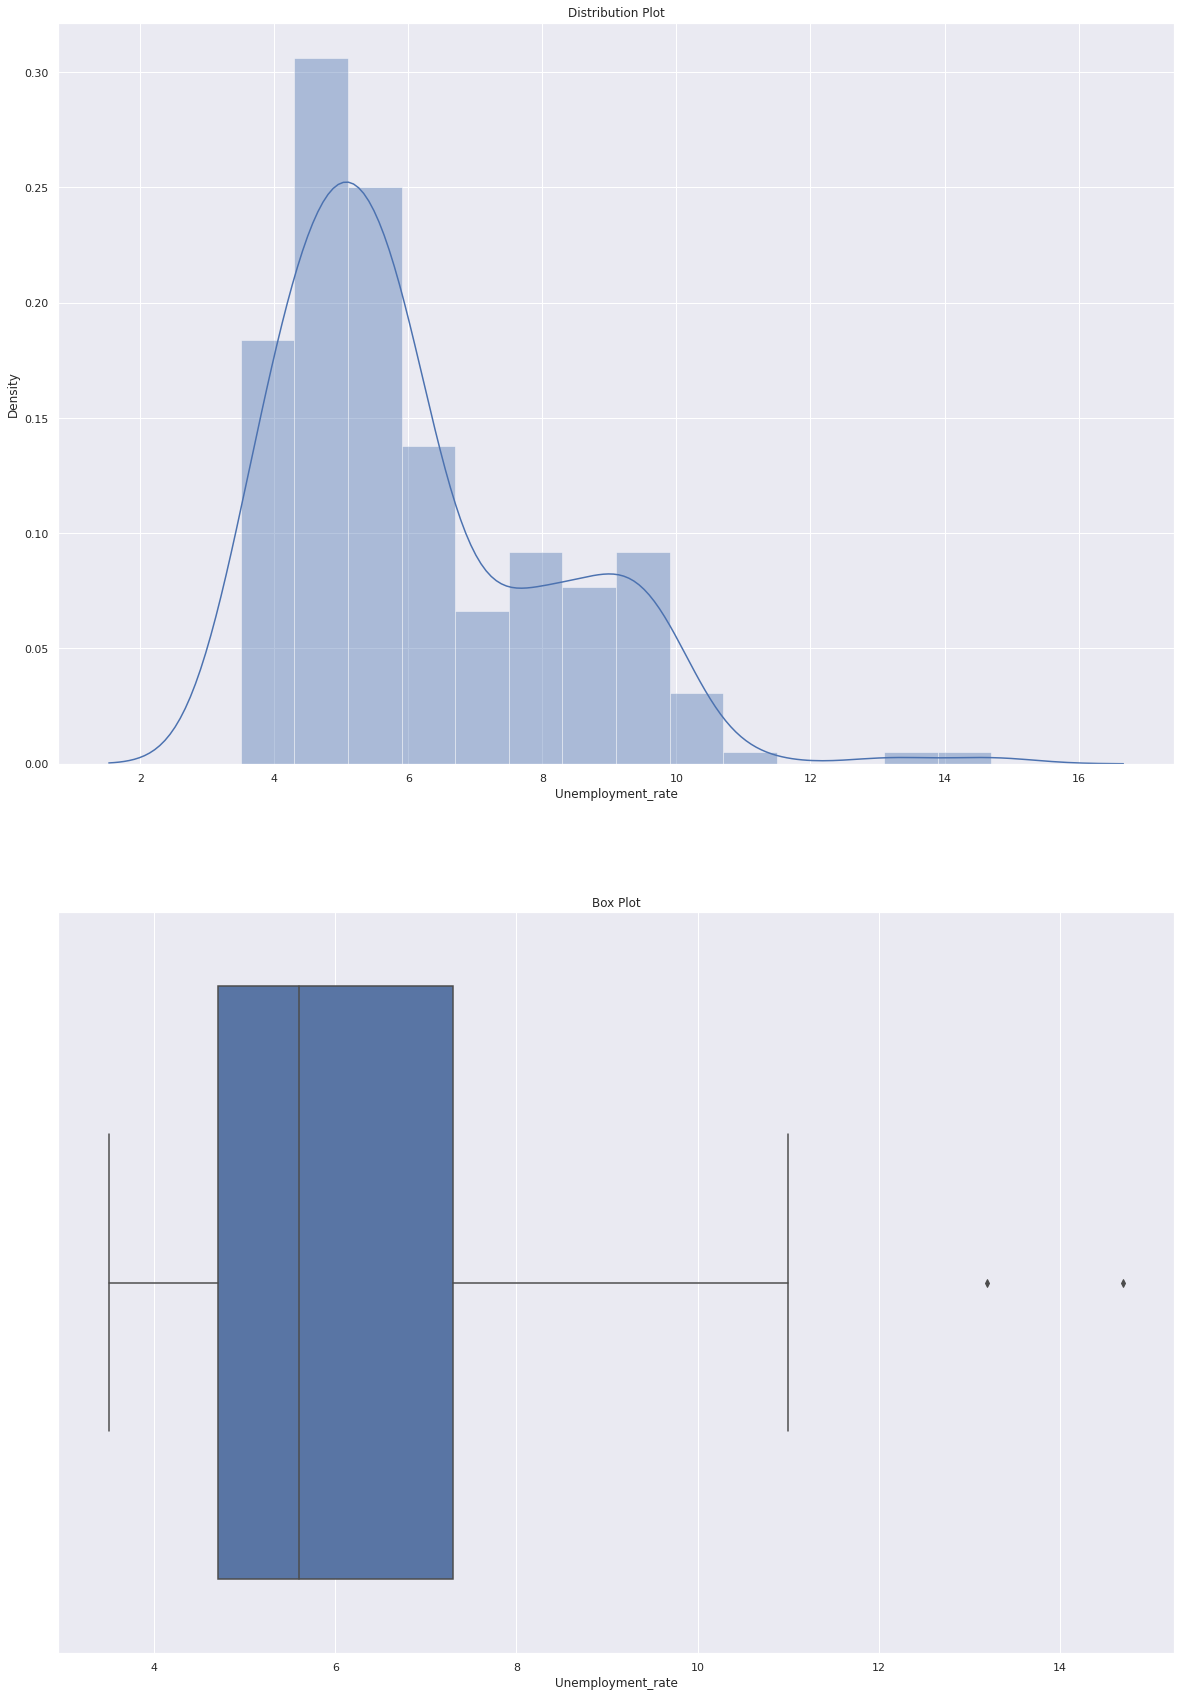

In [ ]:
univariate(df = df, col = 'Unemployment_rate')

From the above charts,

1. Employment_ratio varies between 2 and 16
2. There are couple of outliers in the lower end since this is a live value we can ignore it.



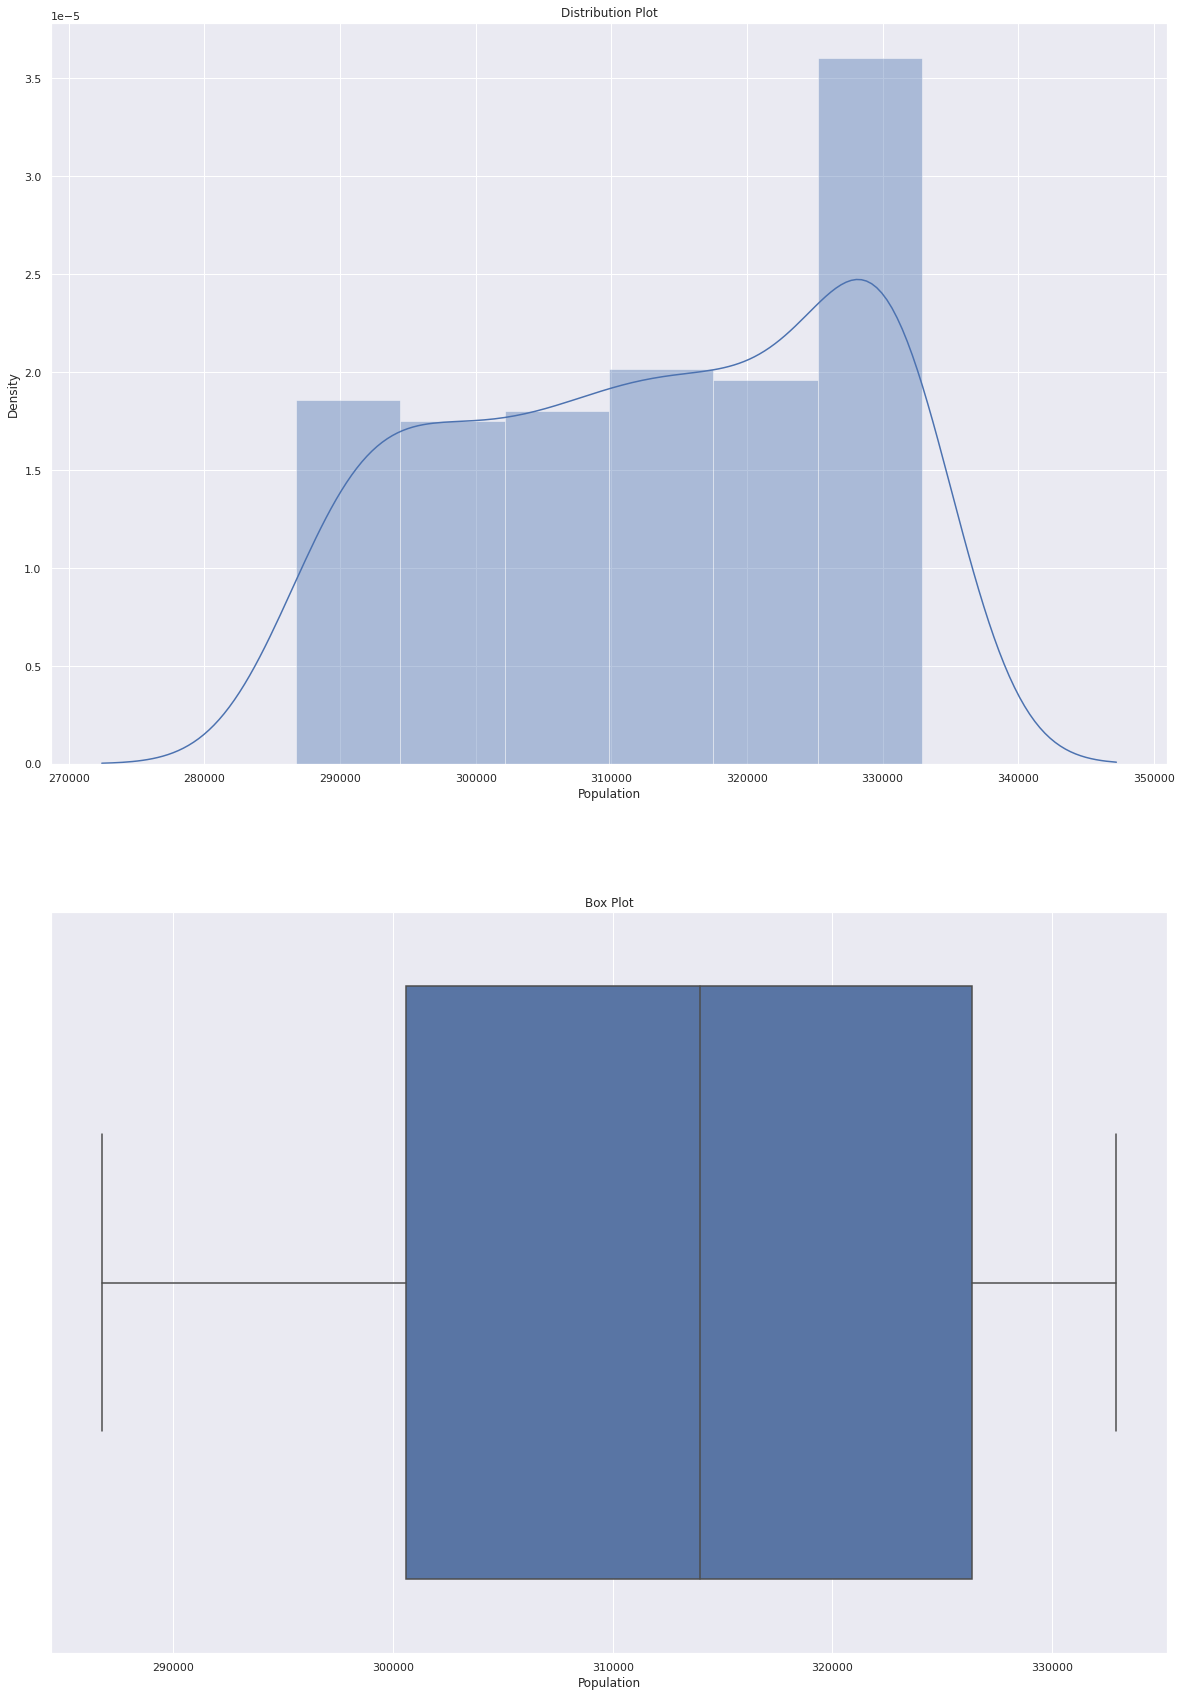

In [ ]:
univariate(df = df, col = 'Population')

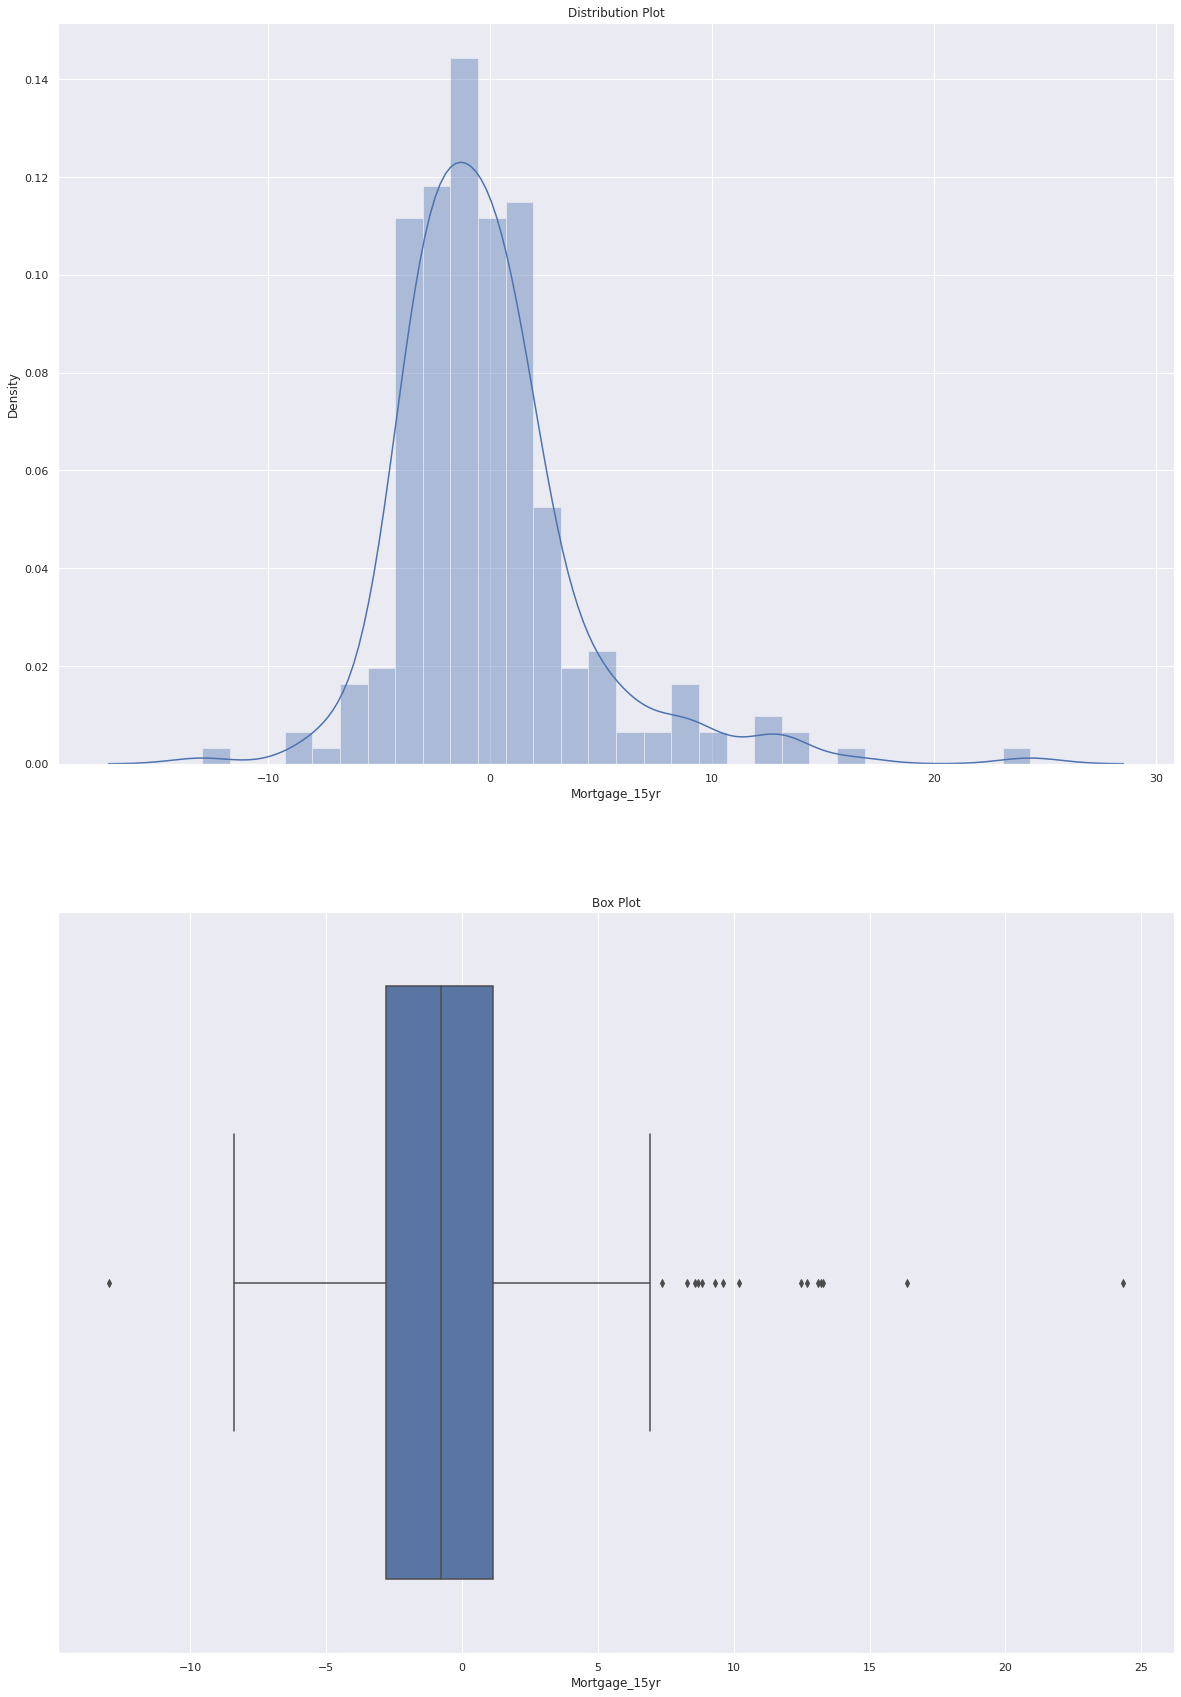

In [ ]:
univariate(df = df, col = 'Mortgage_15yr')

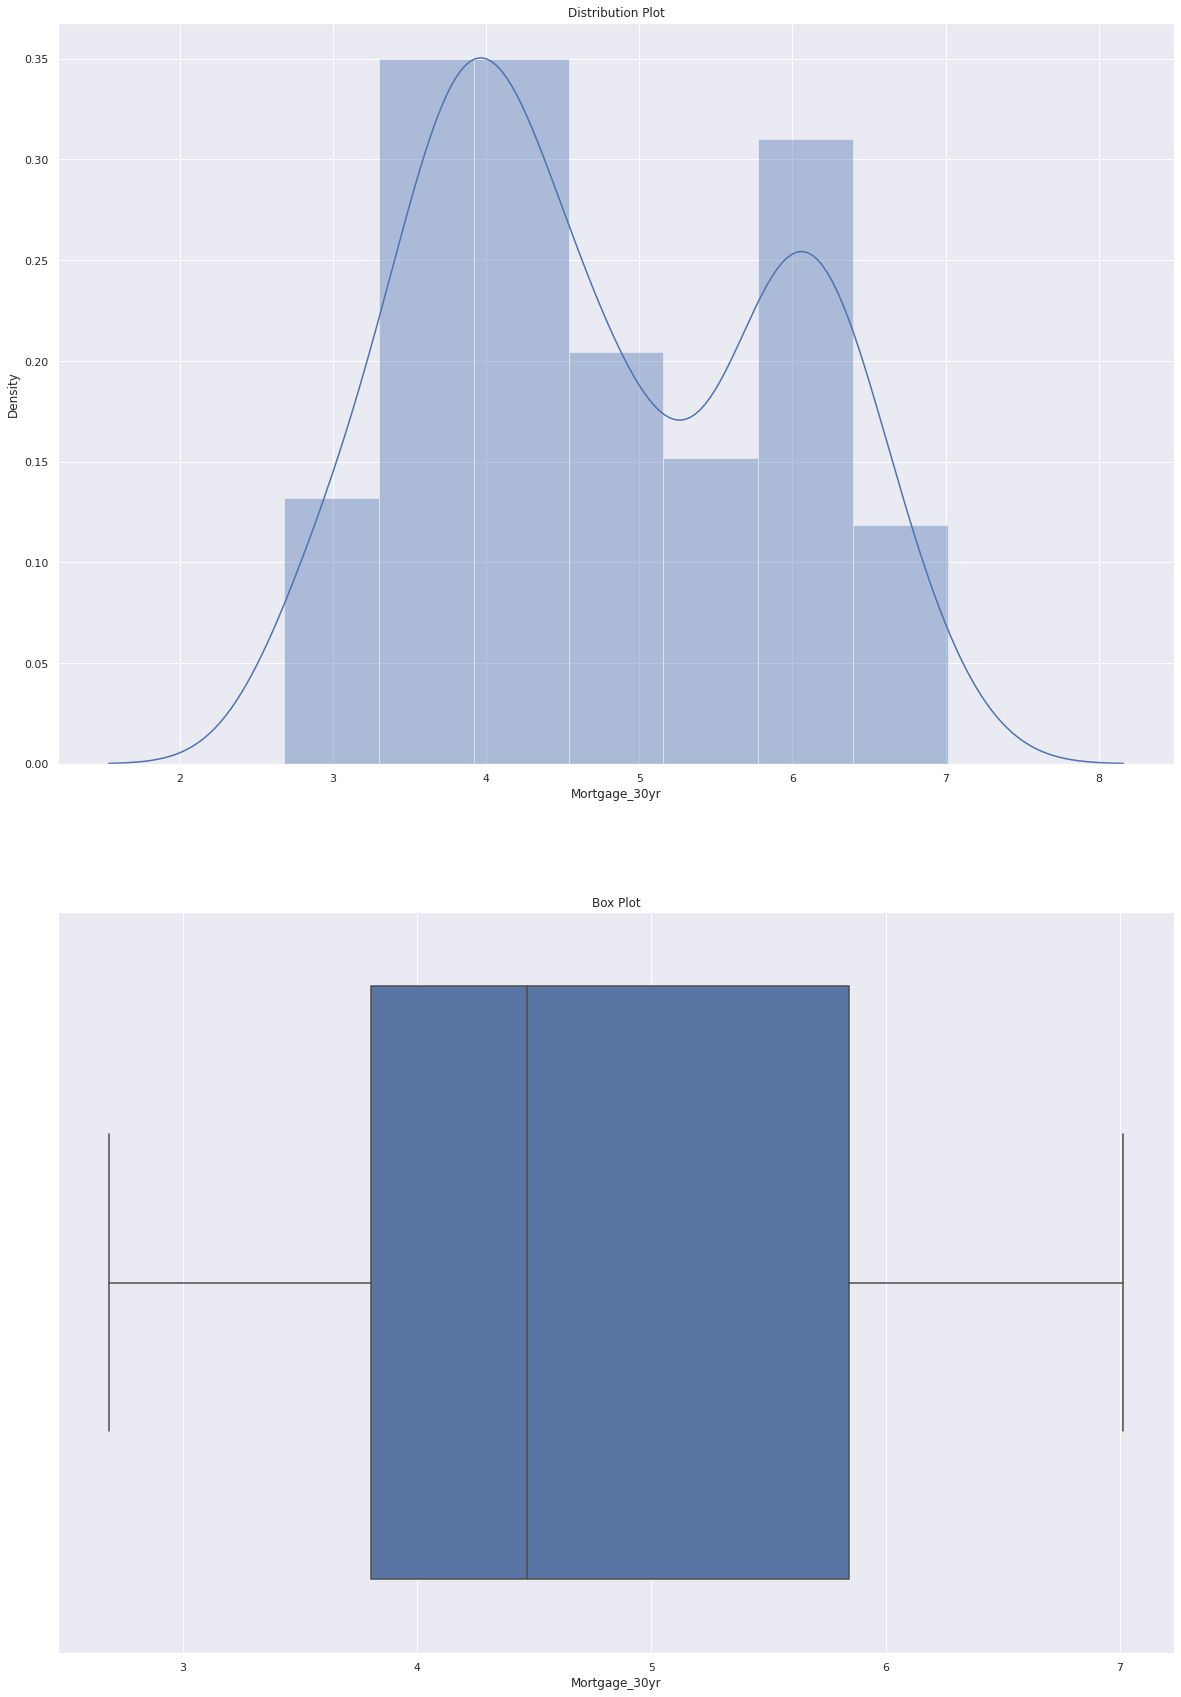

In [ ]:
univariate(df = df, col = 'Mortgage_30yr')

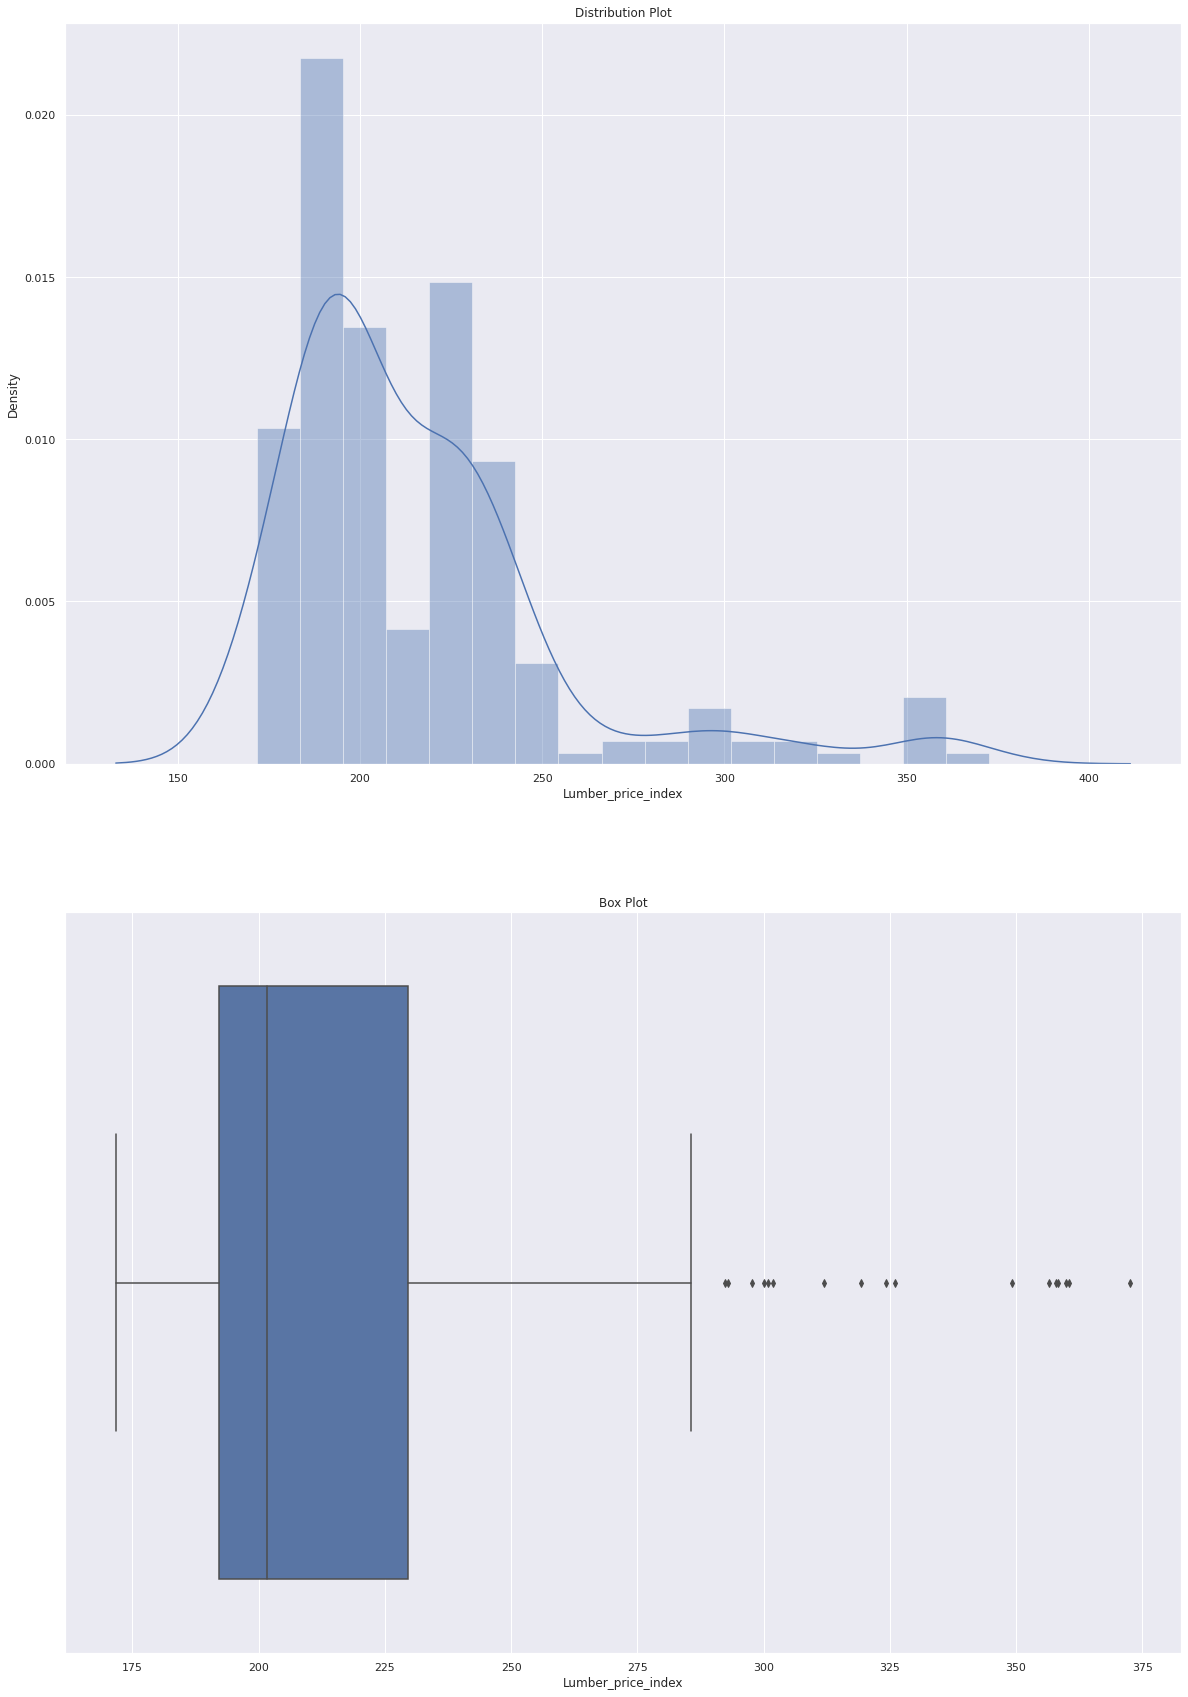

In [ ]:
univariate(df = df, col = 'Lumber_price_index')

From the above plots, 


1. There are lot of variations in lumbar and wood price index
2. Therefore, more outliers present in the data since it is a live data we cannot remove.



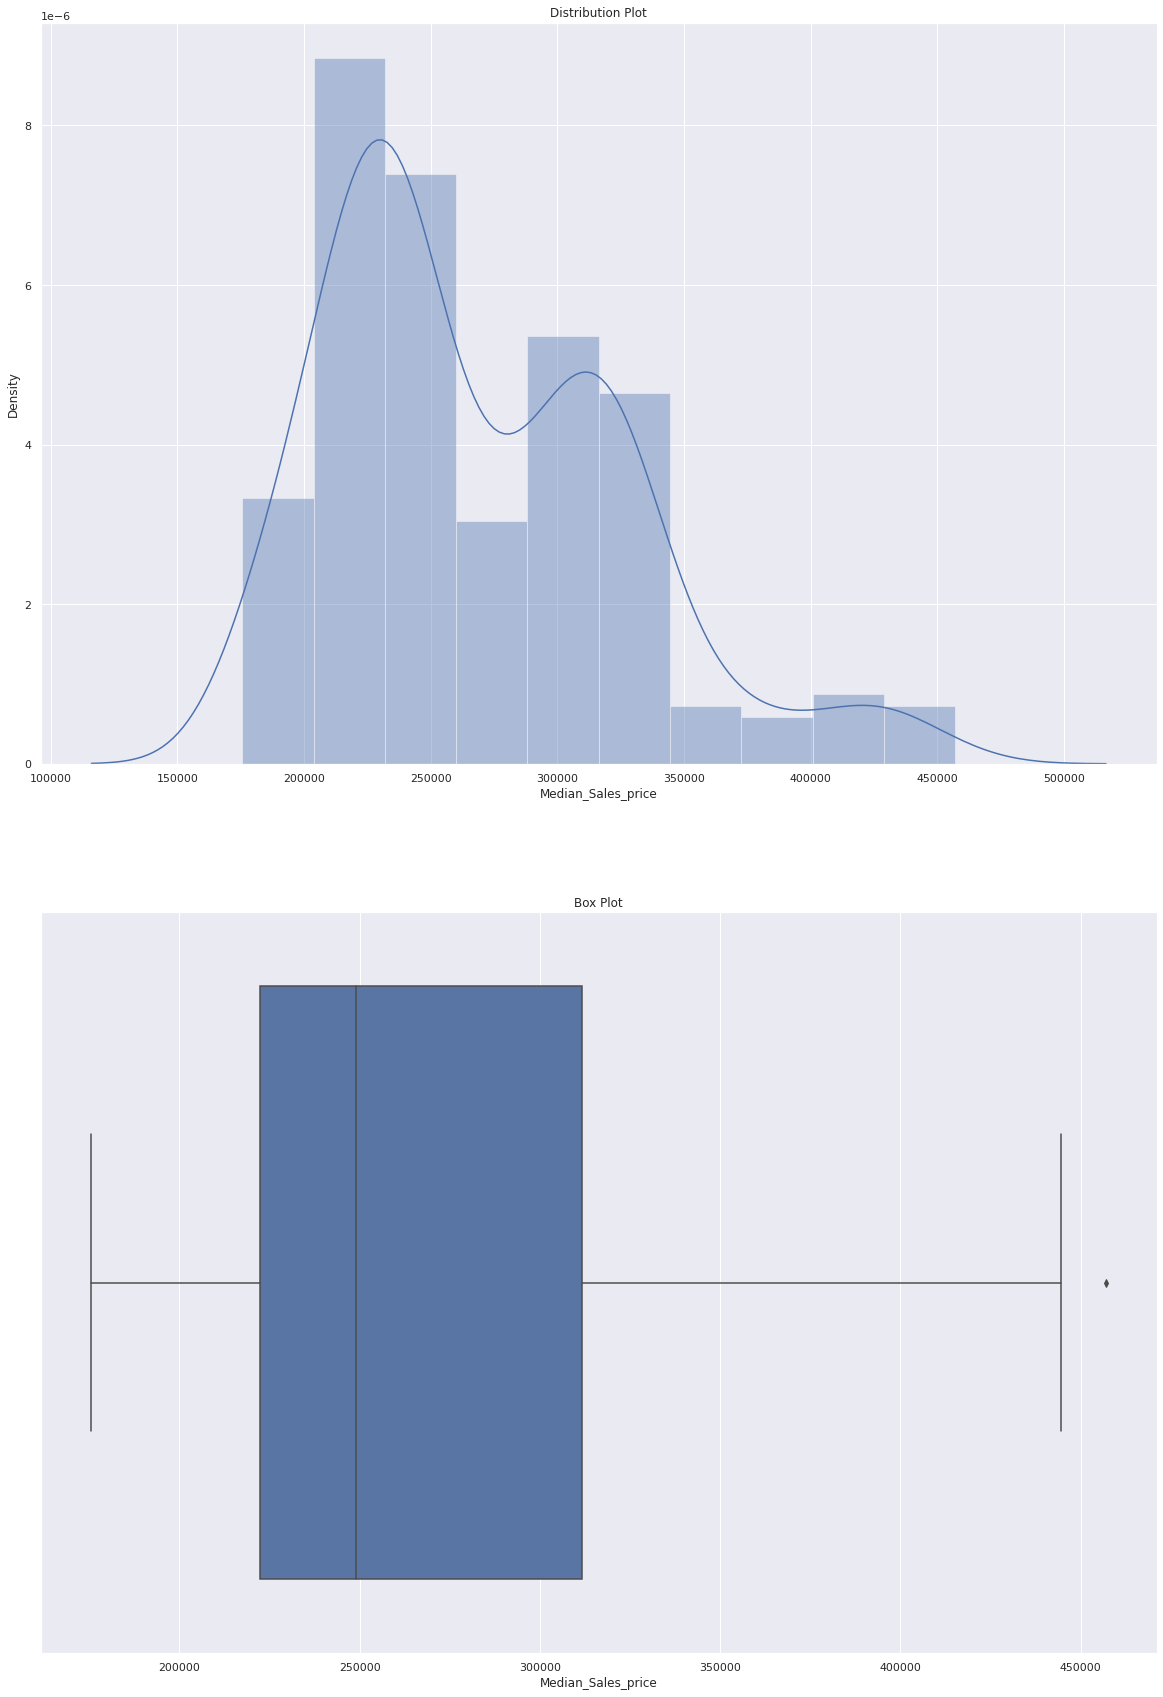

In [ ]:
univariate(df = df, col = 'Median_Sales_price')

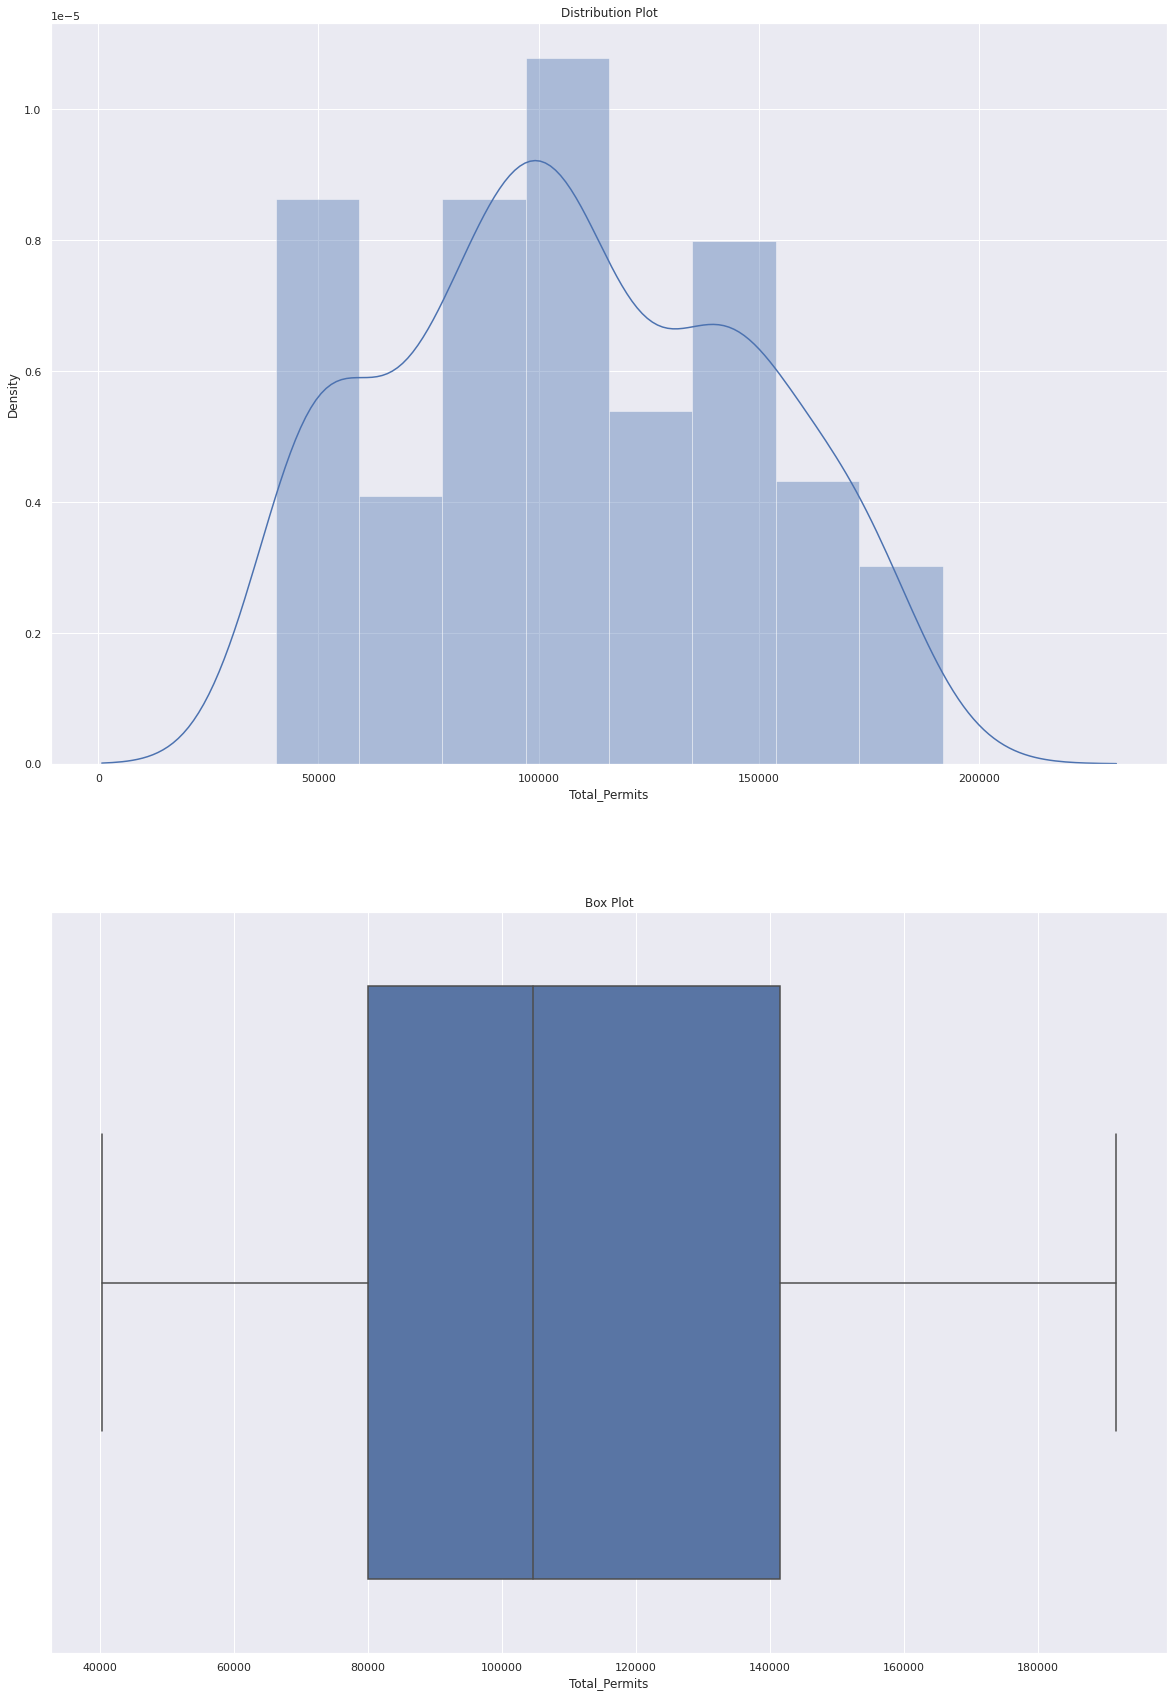

In [ ]:
univariate(df = df, col = 'Total_Permits')

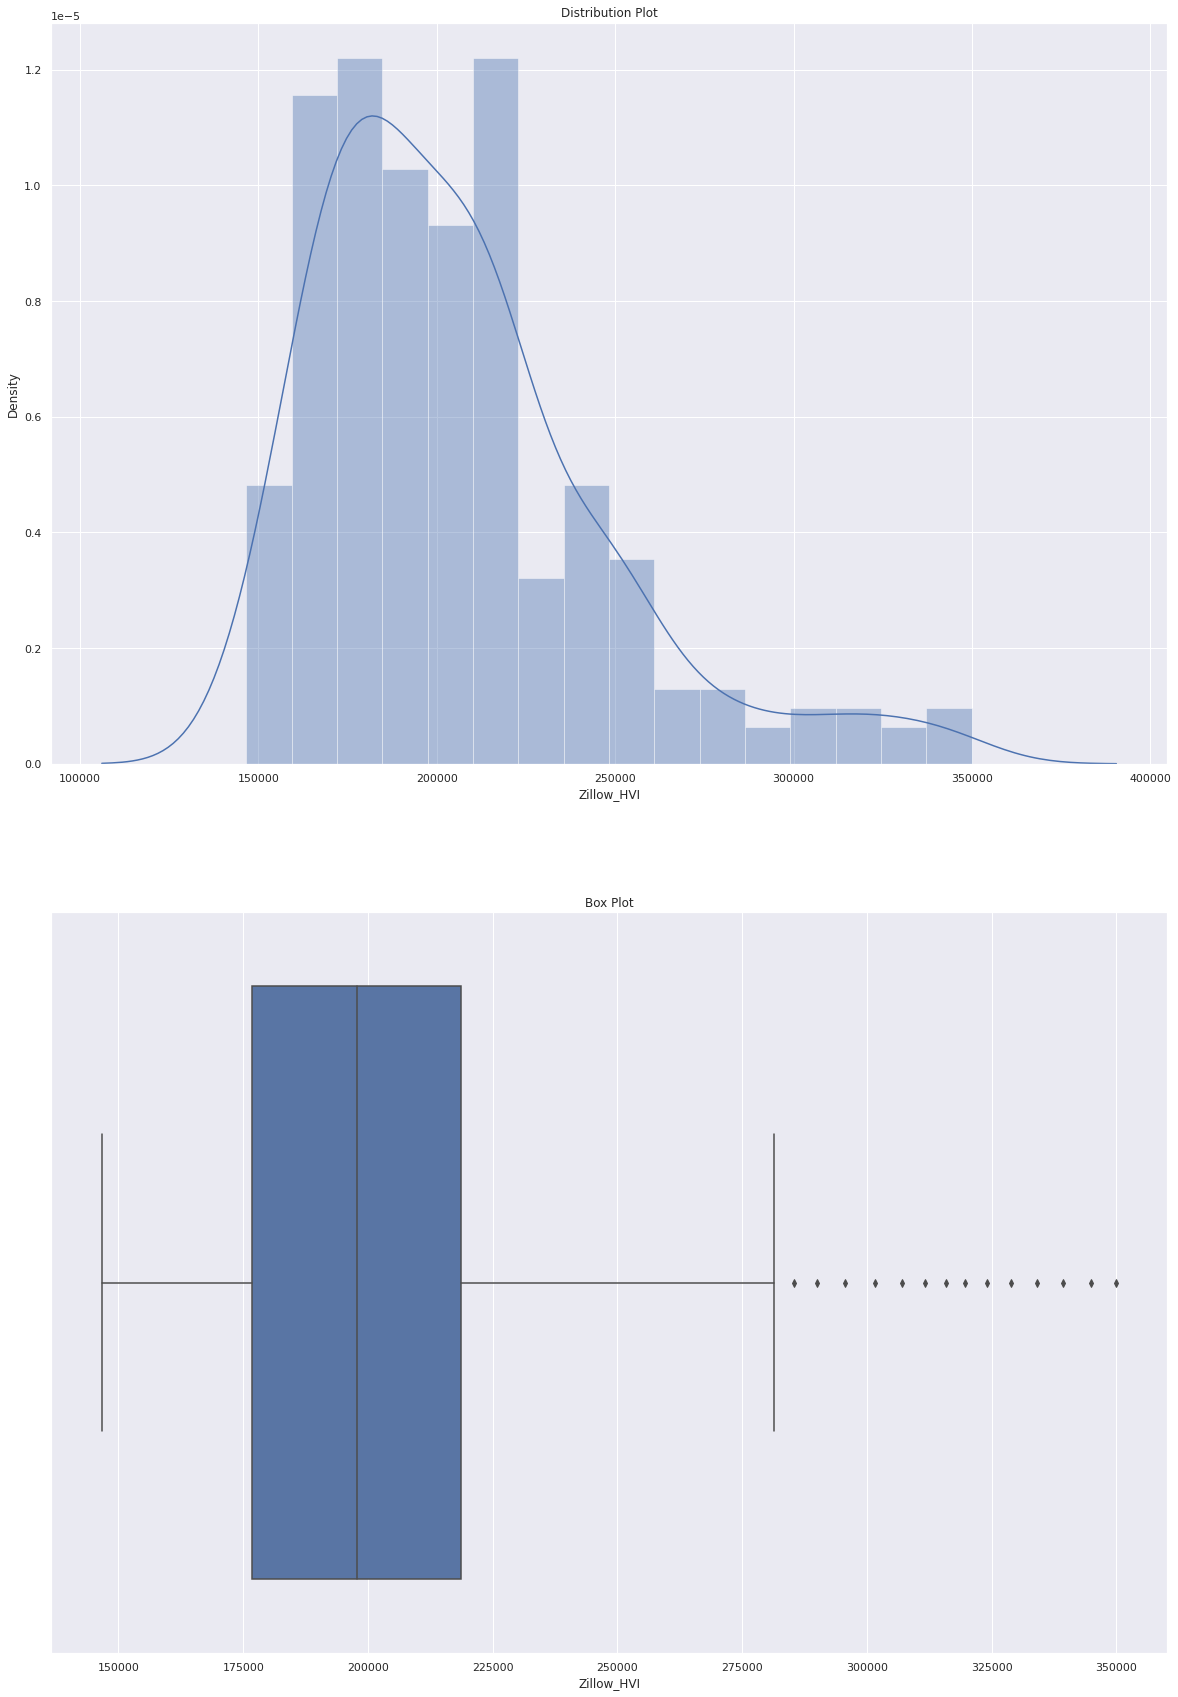

In [ ]:
univariate(df = df, col = 'Zillow_HVI')

We don't need to do for date and year since its equal and not an continous value.

## Checking linearity

Text(0.5, 1.0, 'CPI vs HPI')

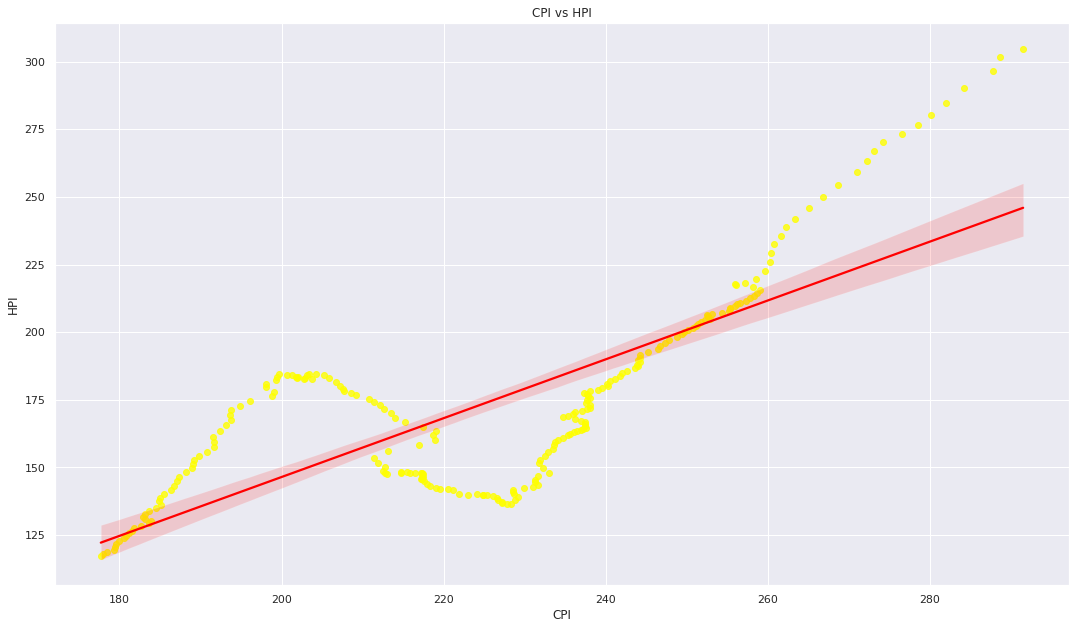

In [ ]:
plt.figure(figsize=(40,60))
plt.subplot(521)
sns.regplot(x=df['CPI'],y=df['HPI'],scatter_kws={'color':'yellow'},line_kws={'color':'red'})
plt.title('CPI vs HPI')

For CPI we have a good positive linear relationship.

Text(0.5, 1.0, 'Employment_ratio vs HPI')

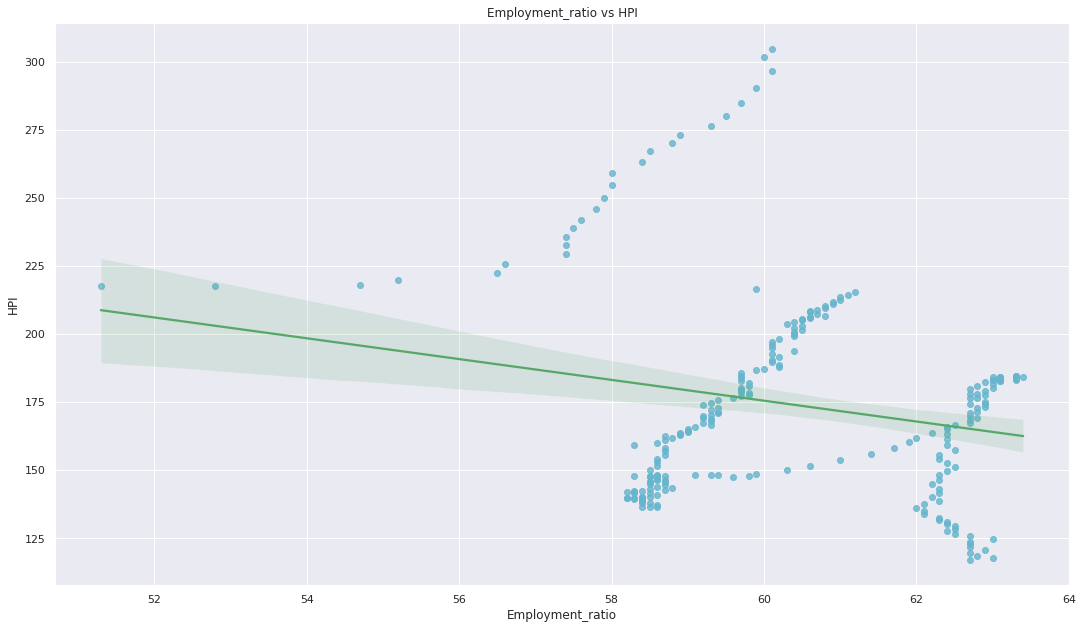

In [ ]:
plt.figure(figsize=(40,60))
plt.subplot(522)
sns.regplot(x=df['Employment_ratio'],y=df['HPI'],scatter_kws={'color':'c'},line_kws={'color':'g'})
plt.title('Employment_ratio vs HPI')

From the above graph, Employment_ratio can see a negative linear relationship.

Text(0.5, 1.0, 'Mortgage_15yr vs HPI')

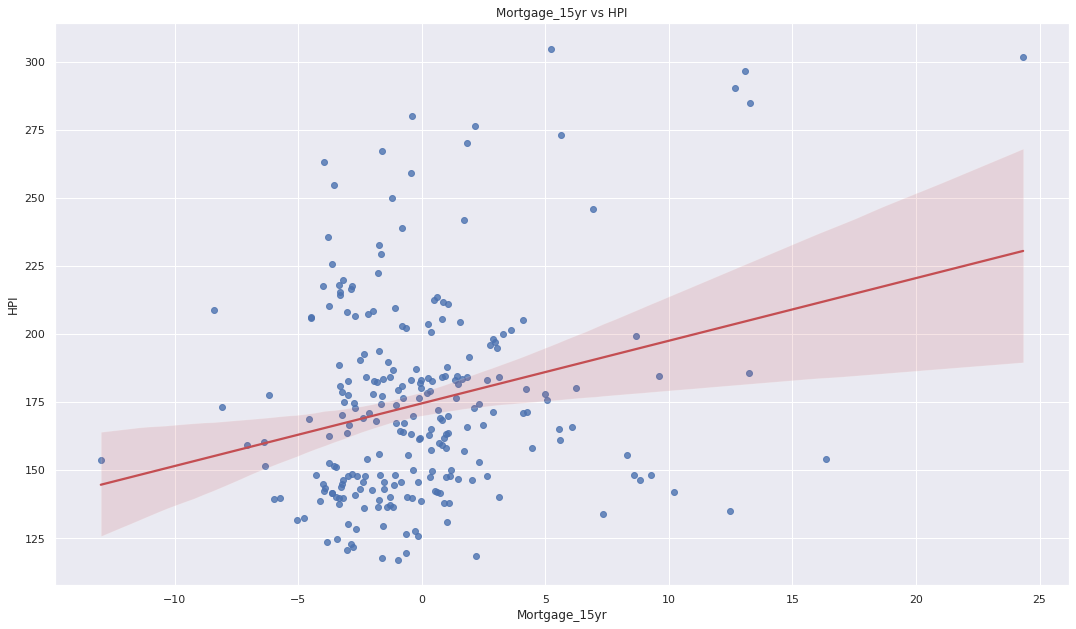

In [ ]:
plt.figure(figsize=(40,60))
plt.subplot(523)
sns.regplot(x=df['Mortgage_15yr'],y=df['HPI'],scatter_kws={'color':'b'},line_kws={'color':'r'})
plt.title('Mortgage_15yr vs HPI')
#no linear relation ship

From the above graph, Mortgage_15yr have a negative linear relationship.

Text(0.5, 1.0, 'Mortgage_30yr vs HPI')

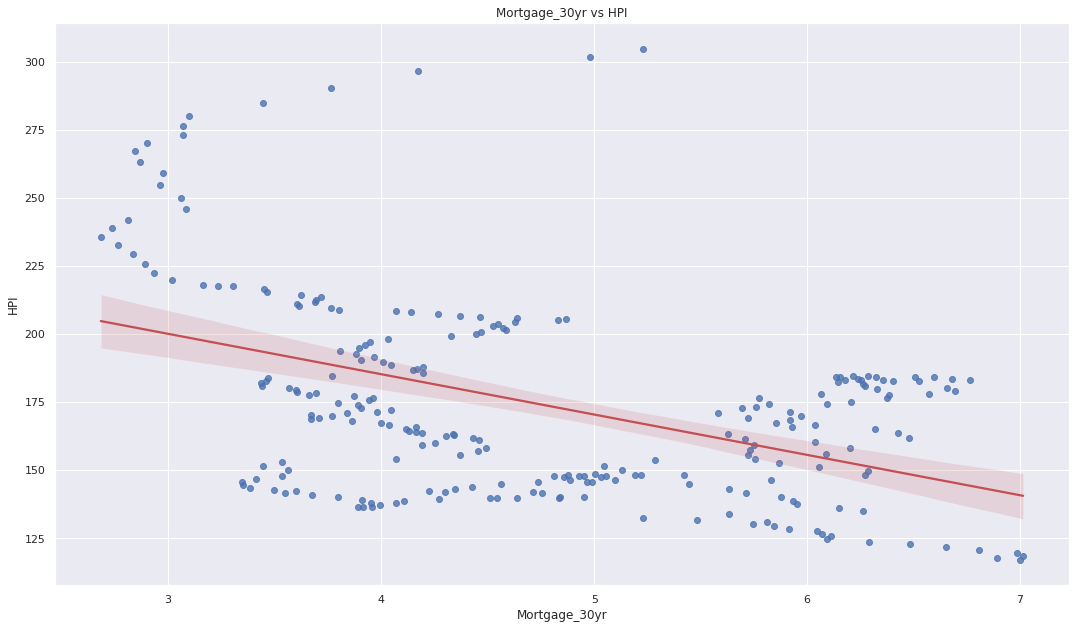

In [ ]:
plt.figure(figsize=(40,60))
plt.subplot(524)
sns.regplot(x=df['Mortgage_30yr'],y=df['HPI'],scatter_kws={'color':'b'},line_kws={'color':'r'})
plt.title('Mortgage_30yr vs HPI')

From the above graph, Mortgage_30yr have a negative linear relationship.

Text(0.5, 1.0, 'Unemployment_rate vs HPI')

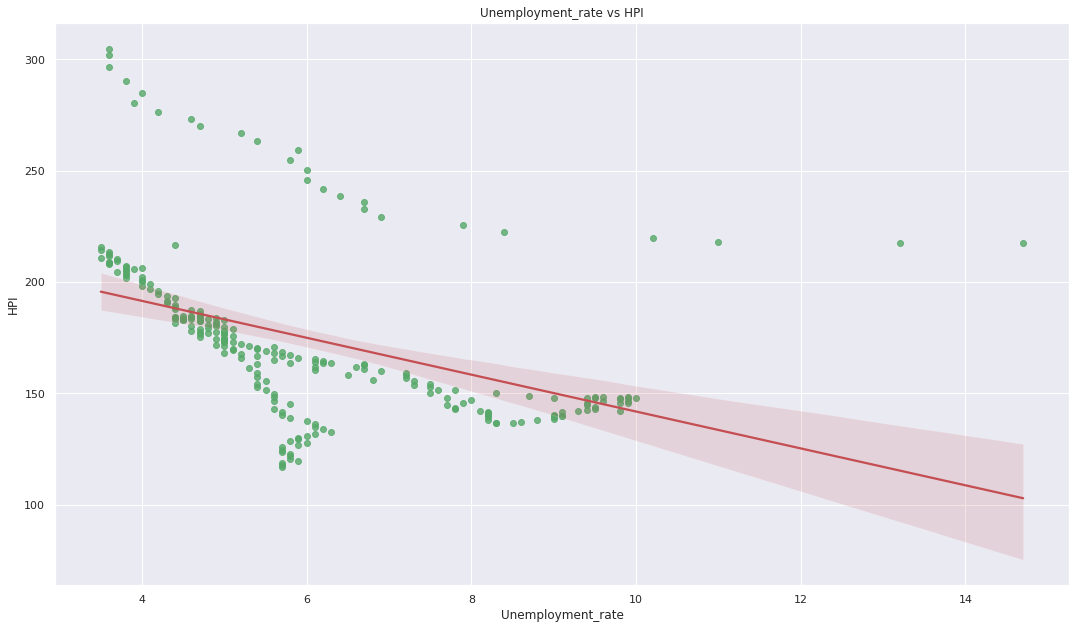

In [ ]:
plt.figure(figsize=(40,60))
plt.subplot(525)
sns.regplot(x=df['Unemployment_rate'],y=df['HPI'],scatter_kws={'color':'g'},line_kws={'color':'r'})
plt.title('Unemployment_rate vs HPI')

From the above graph, Unemployment_rate have a negative linear relationship.

Text(0.5, 1.0, 'Lumber_price_index vs HPI')

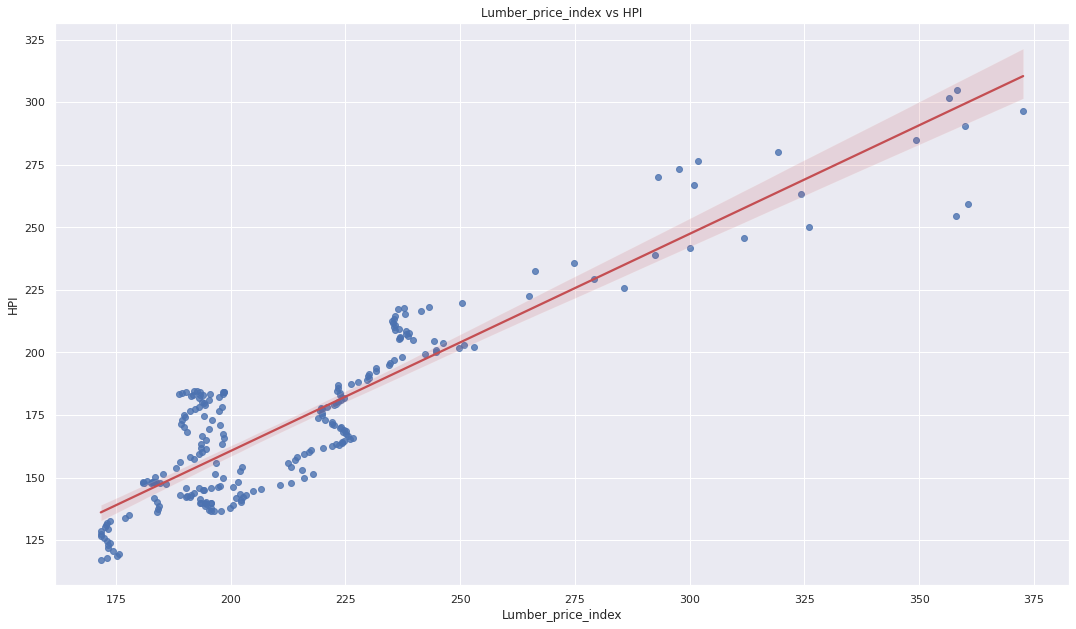

In [ ]:
plt.figure(figsize=(40,60))
plt.subplot(526)
sns.regplot(x=df['Lumber_price_index'],y=df['HPI'],scatter_kws={'color':'b'},line_kws={'color':'r'})
plt.title('Lumber_price_index vs HPI')

From the above graph, Lumber_price_index have positive linear relationship.

Text(0.5, 1.0, 'Median_sales_price vs HPI')

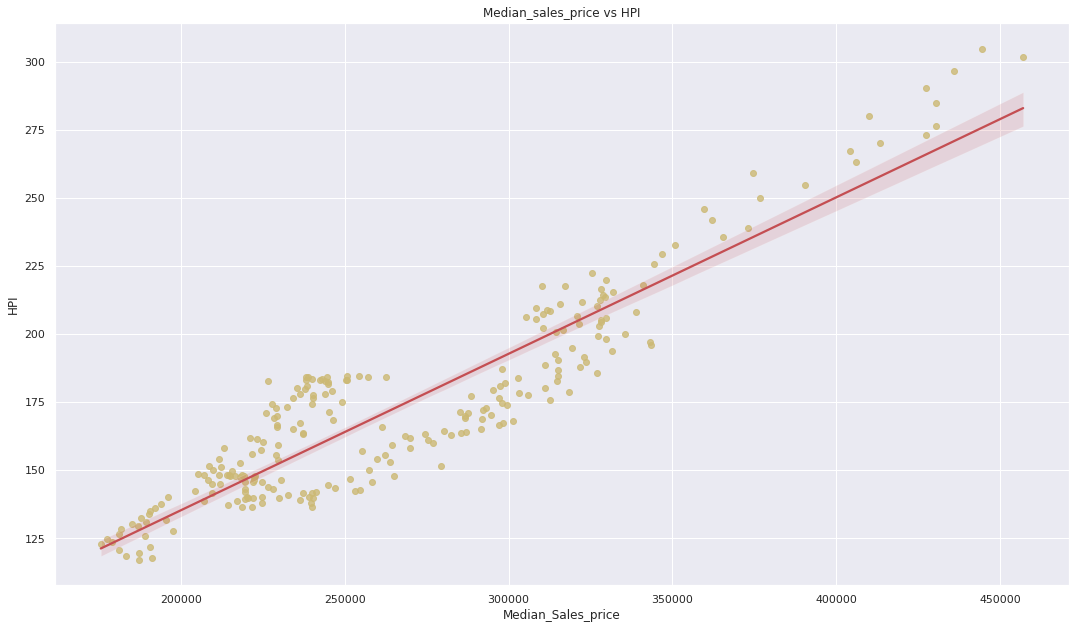

In [ ]:
plt.figure(figsize=(40,60))
plt.subplot(527)
sns.regplot(x=df['Median_Sales_price'],y=df['HPI'],scatter_kws={'color':'y'},line_kws={'color':'r'})
plt.title('Median_sales_price vs HPI')
#no linear relation ship

From the above graph, Median_Sales_price have a positive linear relationships.

Text(0.5, 1.0, 'Population vs HPI')

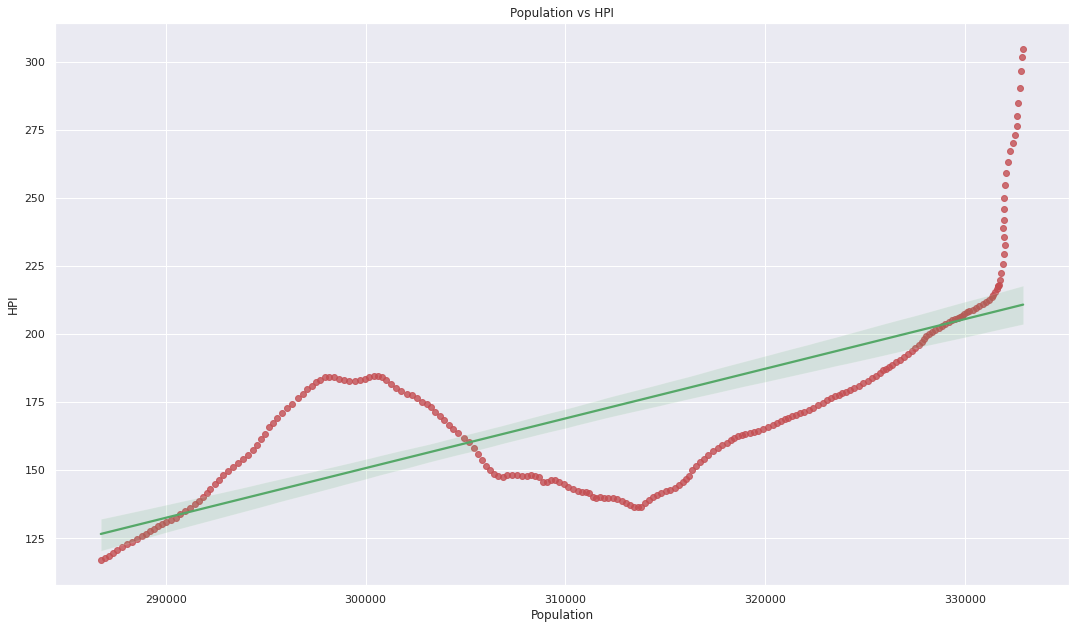

In [ ]:
plt.figure(figsize=(40,60))
plt.subplot(528)
sns.regplot(x=df['Population'],y=df['HPI'],scatter_kws={'color':'r'},line_kws={'color':'g'})
plt.title('Population vs HPI')
#no linear relation ship

From the above graph, Population have a positive linear relationship.

Text(0.5, 1.0, 'Zillow_HVI vs HPI')

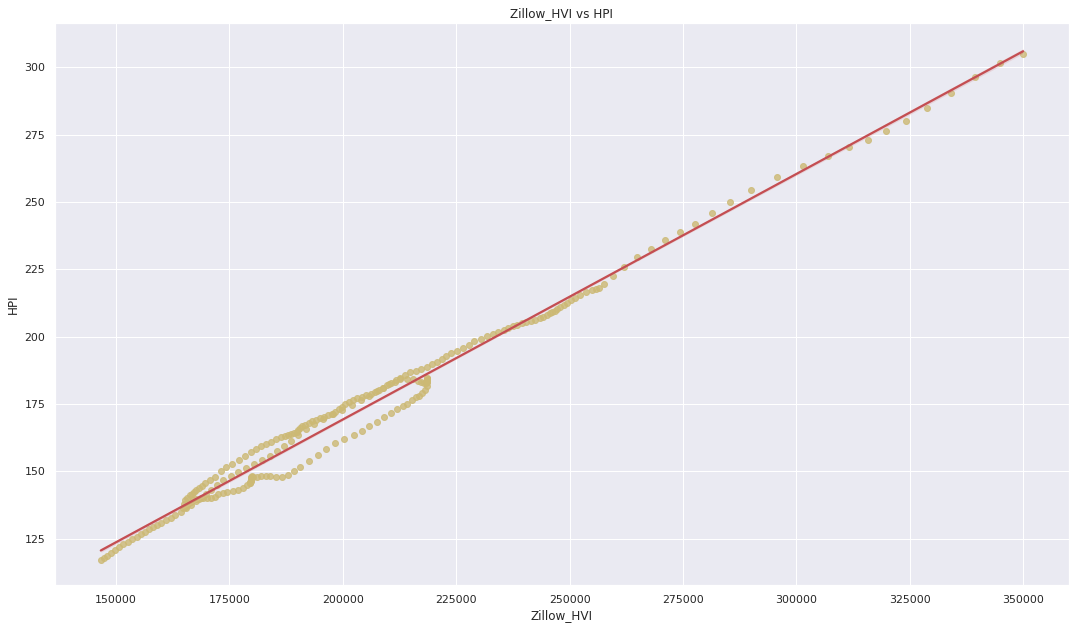

In [ ]:
plt.figure(figsize=(40,60))
plt.subplot(529)
sns.regplot(x=df['Zillow_HVI'],y=df['HPI'],scatter_kws={'color':'y'},line_kws={'color':'r'})
plt.title('Zillow_HVI vs HPI')

From the above graph, Zillow_HVI have a positive linear relationship.

Text(0.5, 1.0, 'Total_Permits vs HPI')

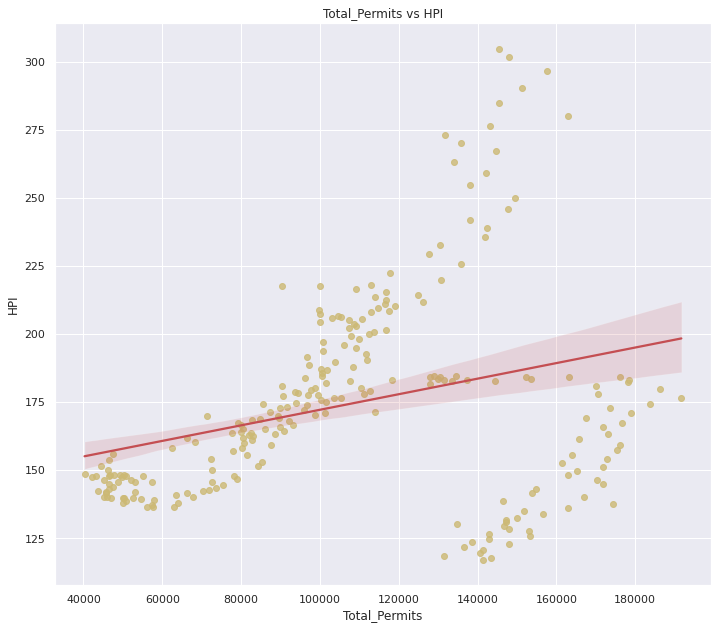

In [ ]:
plt.figure(figsize=(40,60))
plt.subplot(531)
sns.regplot(x=df['Total_Permits'],y=df['HPI'],scatter_kws={'color':'y'},line_kws={'color':'r'})
plt.title('Total_Permits vs HPI')

From the above graph, Total_Permits have a positive linear relationship.

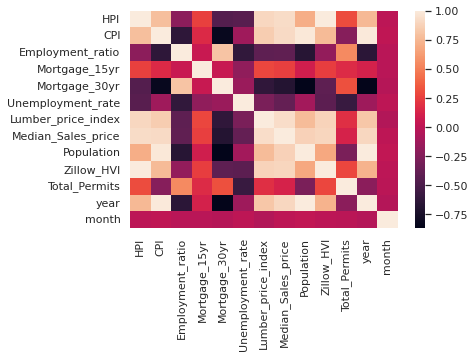

In [ ]:
corrplot = sns.heatmap(df.corr())

We can see from the heat map to infer, all the feature have a linear relationship with other feature execpt month and year, since they are integers and will be used for time-series forecasting.





# Modelling

In [ ]:
df

,HPI,CPI,Employment_ratio,Mortgage_15yr,Mortgage_30yr,Unemployment_rate,Lumber_price_index,Median_Sales_price,Population,Zillow_HVI,Total_Permits,year,month
date,,,,,,,,,,,,,
2002-01-01,117.143,177.700,62.7,-0.95529,6.9975,5.7,171.700,187100.0,286739.0,146655.0,141395.122454,2002,1
2002-02-01,117.844,178.000,63.0,-1.62037,6.8925,5.7,173.000,191100.0,286935.0,147359.0,143460.937494,2002,2
2002-03-01,118.687,178.500,62.8,2.21176,7.0140,5.7,175.300,183400.0,287131.0,148101.0,131492.690186,2002,3
2002-04-01,119.611,179.300,62.7,-0.62922,6.9850,5.9,175.600,187100.0,287343.0,148887.0,140671.867165,2002,4
2002-05-01,120.724,179.500,62.9,-3.01158,6.8060,5.8,174.400,181000.0,287571.0,149724.0,141447.919715,2002,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-01,284.767,281.933,59.7,13.28790,3.4450,4.0,349.222,430500.0,332684.0,328848.0,145334.443500,2022,1
2022-02-01,290.371,284.182,59.9,12.68797,3.7625,3.8,359.934,427400.0,332750.0,334078.0,151150.800354,2022,2
2022-03-01,296.496,287.708,60.1,13.09425,4.1720,3.6,372.661,435900.0,332812.0,339362.0,157715.508361,2022,3


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 245 entries, 2002-01-01 to 2022-05-01
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   HPI                 245 non-null    float64
 1   CPI                 245 non-null    float64
 2   Employment_ratio    245 non-null    float64
 3   Mortgage_15yr       245 non-null    float64
 4   Mortgage_30yr       245 non-null    float64
 5   Unemployment_rate   245 non-null    float64
 6   Lumber_price_index  245 non-null    float64
 7   Median_Sales_price  245 non-null    float64
 8   Population          245 non-null    float64
 9   Zillow_HVI          245 non-null    float64
 10  Total_Permits       245 non-null    float64
 11  year                245 non-null    int64  
 12  month               245 non-null    int64  
dtypes: float64(11), int64(2)
memory usage: 26.8 KB


In [ ]:
x = df.drop(['HPI'],axis = 1)

In [ ]:
x

,CPI,Employment_ratio,Mortgage_15yr,Mortgage_30yr,Unemployment_rate,Lumber_price_index,Median_Sales_price,Population,Zillow_HVI,Total_Permits,year,month
date,,,,,,,,,,,,
2002-01-01,177.700,62.7,-0.95529,6.9975,5.7,171.700,187100.0,286739.0,146655.0,141395.122454,2002,1
2002-02-01,178.000,63.0,-1.62037,6.8925,5.7,173.000,191100.0,286935.0,147359.0,143460.937494,2002,2
2002-03-01,178.500,62.8,2.21176,7.0140,5.7,175.300,183400.0,287131.0,148101.0,131492.690186,2002,3
2002-04-01,179.300,62.7,-0.62922,6.9850,5.9,175.600,187100.0,287343.0,148887.0,140671.867165,2002,4
2002-05-01,179.500,62.9,-3.01158,6.8060,5.8,174.400,181000.0,287571.0,149724.0,141447.919715,2002,5
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-01,281.933,59.7,13.28790,3.4450,4.0,349.222,430500.0,332684.0,328848.0,145334.443500,2022,1
2022-02-01,284.182,59.9,12.68797,3.7625,3.8,359.934,427400.0,332750.0,334078.0,151150.800354,2022,2
2022-03-01,287.708,60.1,13.09425,4.1720,3.6,372.661,435900.0,332812.0,339362.0,157715.508361,2022,3


In [ ]:
y = df['HPI']
y = pd.DataFrame(y)

In [ ]:
y

,HPI
date,
2002-01-01,117.143
2002-02-01,117.844
2002-03-01,118.687
2002-04-01,119.611
2002-05-01,120.724
...,...
2022-01-01,284.767
2022-02-01,290.371
2022-03-01,296.496


In [ ]:
df

,HPI,CPI,Employment_ratio,Mortgage_15yr,Mortgage_30yr,Unemployment_rate,Lumber_price_index,Median_Sales_price,Population,Zillow_HVI,Total_Permits,year,month
date,,,,,,,,,,,,,
2002-01-01,117.143,177.700,62.7,-0.95529,6.9975,5.7,171.700,187100.0,286739.0,146655.0,141395.122454,2002,1
2002-02-01,117.844,178.000,63.0,-1.62037,6.8925,5.7,173.000,191100.0,286935.0,147359.0,143460.937494,2002,2
2002-03-01,118.687,178.500,62.8,2.21176,7.0140,5.7,175.300,183400.0,287131.0,148101.0,131492.690186,2002,3
2002-04-01,119.611,179.300,62.7,-0.62922,6.9850,5.9,175.600,187100.0,287343.0,148887.0,140671.867165,2002,4
2002-05-01,120.724,179.500,62.9,-3.01158,6.8060,5.8,174.400,181000.0,287571.0,149724.0,141447.919715,2002,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-01,284.767,281.933,59.7,13.28790,3.4450,4.0,349.222,430500.0,332684.0,328848.0,145334.443500,2022,1
2022-02-01,290.371,284.182,59.9,12.68797,3.7625,3.8,359.934,427400.0,332750.0,334078.0,151150.800354,2022,2
2022-03-01,296.496,287.708,60.1,13.09425,4.1720,3.6,372.661,435900.0,332812.0,339362.0,157715.508361,2022,3


We need to scale the data since data are in various range.

In [ ]:
scaler = StandardScaler()

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.3, random_state = 4)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 245 entries, 2002-01-01 to 2022-05-01
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   HPI                 245 non-null    float64
 1   CPI                 245 non-null    float64
 2   Employment_ratio    245 non-null    float64
 3   Mortgage_15yr       245 non-null    float64
 4   Mortgage_30yr       245 non-null    float64
 5   Unemployment_rate   245 non-null    float64
 6   Lumber_price_index  245 non-null    float64
 7   Median_Sales_price  245 non-null    float64
 8   Population          245 non-null    float64
 9   Zillow_HVI          245 non-null    float64
 10  Total_Permits       245 non-null    float64
 11  year                245 non-null    int64  
 12  month               245 non-null    int64  
dtypes: float64(11), int64(2)
memory usage: 26.8 KB


In [ ]:
# Import library for Linear Regression
from sklearn import metrics
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
# Create a Linear regressor
lm = LinearRegression()

# Train the model using the training sets 
lm.fit(x_train, y_train)

LinearRegression()

In [ ]:
y_pred = lm.predict(x_train)
y_pred

array([[228.79371195],
       [222.29519816],
       [165.42399295],
       [163.60732329],
       [149.02520415],
       [154.84982906],
       [199.4737108 ],
       [132.33084853],
       [168.61665911],
       [146.47577547],
       [215.04997448],
       [209.0689213 ],
       [135.76908378],
       [118.09978834],
       [182.5997048 ],
       [206.18716153],
       [149.51265648],
       [142.08281899],
       [210.52070173],
       [193.34766538],
       [121.0885308 ],
       [142.1880079 ],
       [144.03255137],
       [203.99542703],
       [163.38581496],
       [183.40166296],
       [172.87242002],
       [148.30632942],
       [167.29142117],
       [137.16077074],
       [145.36746259],
       [186.42435309],
       [199.47452277],
       [286.62016407],
       [303.0259986 ],
       [139.30139358],
       [158.44705035],
       [138.97422456],
       [169.51001683],
       [259.10536268],
       [126.29178345],
       [272.80570924],
       [123.05221663],
       [161

In [ ]:
print('R^2:',metrics.r2_score(y_train, y_pred))
print('Adjusted R^2:',1 - (1-metrics.r2_score(y_train, y_pred))*(len(y_train)-1)/(len(y_train)-x_train.shape[1]-1))
print('MAE:',metrics.mean_absolute_error(y_train, y_pred))
print('MSE:',metrics.mean_squared_error(y_train, y_pred))
print('RMSE:',np.sqrt(metrics.mean_squared_error(y_train, y_pred)))

R^2: 0.9990126847718607
Adjusted R^2: 0.9989376988051666
MAE: 0.9771502074656235
MSE: 1.4818632421191191
RMSE: 1.2173180529833274


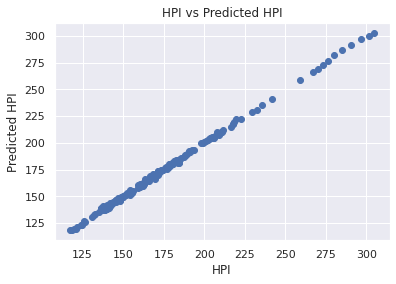

In [ ]:
# Visualizing the differences between actual prices and predicted values
plt.scatter(y_train, y_pred)
plt.xlabel("HPI")
plt.ylabel("Predicted HPI")
plt.title("HPI vs Predicted HPI")
plt.show()

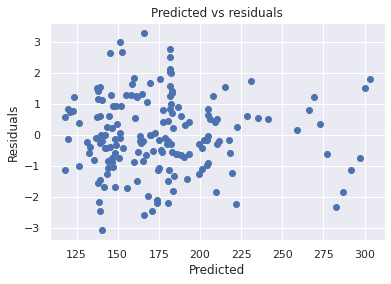

In [ ]:
# Checking residuals
plt.scatter(y_pred,y_train-y_pred)
plt.title("Predicted vs residuals")
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.show()

In [ ]:
y_test_pred = lm.predict(x_test)
y_test_pred

array([[128.72064814],
       [146.39001713],
       [178.10514891],
       [122.59158825],
       [186.45324259],
       [156.75875685],
       [176.45699107],
       [177.96113497],
       [177.58122707],
       [181.01296264],
       [211.42739446],
       [174.49721148],
       [148.50315658],
       [151.88627958],
       [155.19462334],
       [197.31427884],
       [165.91301192],
       [262.10037237],
       [158.38008776],
       [173.67863808],
       [145.35169925],
       [145.48343486],
       [144.45659354],
       [178.3132529 ],
       [209.49990027],
       [182.28669182],
       [245.25986884],
       [129.66800248],
       [166.43060679],
       [129.36753061],
       [249.4485934 ],
       [170.62026156],
       [146.86805018],
       [146.247584  ],
       [211.20023427],
       [159.39539858],
       [139.32035718],
       [118.39563736],
       [135.45588256],
       [153.50458124],
       [137.03049908],
       [146.27937426],
       [173.04960369],
       [176

In [ ]:
# Model Evaluation
acc_linreg = metrics.r2_score(y_test, y_test_pred)
print('R^2:', acc_linreg)
print('Adjusted R^2:',1 - (1-metrics.r2_score(y_test, y_test_pred))*(len(y_test)-1)/(len(y_test)-x_test.shape[1]-1))
print('MAE:',metrics.mean_absolute_error(y_test, y_test_pred))
print('MSE:',metrics.mean_squared_error(y_test, y_test_pred))
print('RMSE:',np.sqrt(metrics.mean_squared_error(y_test, y_test_pred)))

R^2: 0.9982994998175713
Adjusted R^2: 0.9979649751915197
MAE: 1.0559182812104442
MSE: 1.8263235425643518
RMSE: 1.3514153849073762


In [ ]:
# Import Random Forest Regressor
from sklearn.ensemble import RandomForestRegressor

# Create a Random Forest Regressor
reg = RandomForestRegressor()

# Train the model using the training sets 
reg.fit(x_train, y_train)

RandomForestRegressor()

In [ ]:
y_pred = reg.predict(x_train)
y_pred

array([230.27772, 223.26291, 164.77896, 163.18053, 149.1145 , 157.6789 ,
       199.53314, 131.89259, 166.5542 , 145.94723, 217.73272, 209.77851,
       134.87075, 119.11201, 183.73141, 206.79118, 149.30651, 142.30691,
       210.33487, 192.21765, 121.6528 , 142.54368, 143.79037, 203.11626,
       163.80158, 182.09836, 173.12902, 148.62024, 166.04699, 138.84149,
       145.16305, 187.26215, 199.06585, 284.74358, 301.26765, 140.57447,
       159.86139, 137.03991, 171.9611 , 258.62266, 126.53807, 270.87507,
       123.66163, 161.31366, 136.17563, 170.16511, 268.07315, 161.85894,
       200.66464, 180.78391, 209.17086, 157.70734, 139.53979, 203.72461,
       207.97802, 136.87738, 162.89192, 177.17386, 218.51626, 181.54236,
       183.19804, 151.10638, 290.5463 , 136.87045, 237.05977, 155.17621,
       217.44397, 158.52557, 130.44565, 142.11784, 150.26919, 184.04882,
       145.72813, 146.52024, 131.86707, 178.90881, 205.40284, 231.79555,
       120.83931, 217.63415, 185.13433, 183.26475, 

In [ ]:
# Model Evaluation
print('R^2:',metrics.r2_score(y_train, y_pred))
print('Adjusted R^2:',1 - (1-metrics.r2_score(y_train, y_pred))*(len(y_train)-1)/(len(y_train)-x_train.shape[1]-1))
print('MAE:',metrics.mean_absolute_error(y_train, y_pred))
print('MSE:',metrics.mean_squared_error(y_train, y_pred))
print('RMSE:',np.sqrt(metrics.mean_squared_error(y_train, y_pred)))

R^2: 0.999584360419517
Adjusted R^2: 0.9995527928564424
MAE: 0.552300701754362
MSE: 0.623834210932181
RMSE: 0.7898317611568815


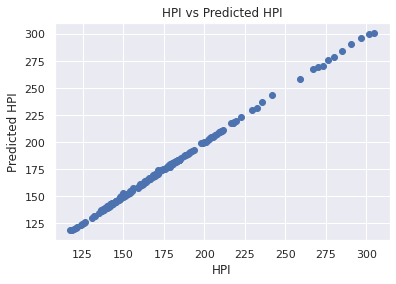

In [ ]:
# Visualizing the differences between actual prices and predicted values
plt.scatter(y_train, y_pred)
plt.xlabel("HPI")
plt.ylabel("Predicted HPI")
plt.title("HPI vs Predicted HPI")
plt.show()

In [ ]:
y_pred

array([230.27772, 223.26291, 164.77896, 163.18053, 149.1145 , 157.6789 ,
       199.53314, 131.89259, 166.5542 , 145.94723, 217.73272, 209.77851,
       134.87075, 119.11201, 183.73141, 206.79118, 149.30651, 142.30691,
       210.33487, 192.21765, 121.6528 , 142.54368, 143.79037, 203.11626,
       163.80158, 182.09836, 173.12902, 148.62024, 166.04699, 138.84149,
       145.16305, 187.26215, 199.06585, 284.74358, 301.26765, 140.57447,
       159.86139, 137.03991, 171.9611 , 258.62266, 126.53807, 270.87507,
       123.66163, 161.31366, 136.17563, 170.16511, 268.07315, 161.85894,
       200.66464, 180.78391, 209.17086, 157.70734, 139.53979, 203.72461,
       207.97802, 136.87738, 162.89192, 177.17386, 218.51626, 181.54236,
       183.19804, 151.10638, 290.5463 , 136.87045, 237.05977, 155.17621,
       217.44397, 158.52557, 130.44565, 142.11784, 150.26919, 184.04882,
       145.72813, 146.52024, 131.86707, 178.90881, 205.40284, 231.79555,
       120.83931, 217.63415, 185.13433, 183.26475, 

In [ ]:
y_train = pd.Series(y_train['HPI'])

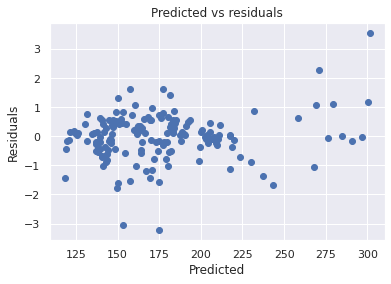

In [ ]:
plt.scatter(y_pred,y_train-y_pred)
plt.title("Predicted vs residuals")
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.show()

In [ ]:
# Predicting Test data with the model
y_test_pred = reg.predict(x_test)
y_test_pred

array([127.99423, 148.13105, 178.74708, 122.38775, 186.14971, 156.87716,
       174.61272, 180.41467, 180.90198, 180.04559, 211.85865, 174.91567,
       148.625  , 156.65094, 156.46173, 196.16797, 167.65738, 264.47691,
       158.70177, 176.84346, 148.87463, 147.60278, 144.04817, 181.20268,
       208.67732, 182.16891, 243.39181, 129.1676 , 165.34405, 130.19154,
       249.64479, 171.85072, 149.82335, 148.1837 , 211.08184, 161.11637,
       141.70279, 119.39177, 133.27709, 154.8258 , 137.15225, 149.63441,
       170.68228, 175.78508, 168.8065 , 167.11642, 198.57998, 174.67772,
       216.20552, 257.92894, 169.60976, 143.13604, 205.78119, 207.4844 ,
       214.95396, 228.88652, 159.86169, 137.63313, 156.16781, 147.17199,
       150.77007, 142.35143, 194.20668, 163.55519, 201.95872, 245.49035,
       144.19909, 128.28245, 142.54119, 164.64149, 142.72468, 166.37622,
       140.59202, 182.1245 ])

In [ ]:
# Model Evaluation
acc_rf = metrics.r2_score(y_test, y_test_pred)
print('R^2:', acc_rf)
print('Adjusted R^2:',1 - (1-metrics.r2_score(y_test, y_test_pred))*(len(y_test)-1)/(len(y_test)-x_test.shape[1]-1))
print('MAE:',metrics.mean_absolute_error(y_test, y_test_pred))
print('MSE:',metrics.mean_squared_error(y_test, y_test_pred))
print('RMSE:',np.sqrt(metrics.mean_squared_error(y_test, y_test_pred)))

R^2: 0.9958950089373343
Adjusted R^2: 0.9950874697118919
MAE: 1.4722672972972863
MSE: 4.408727442213505
RMSE: 2.099696988189845


In [ ]:
reg.score(x_train,y_train)

0.999584360419517

In [ ]:
reg.score(x_test,y_test)

0.9958950089373343

## XGB

In [ ]:
# Import XGBoost Regressor
from xgboost import XGBRegressor

#Create a XGBoost Regressor
reg2 = XGBRegressor()

# Train the model using the training sets 
reg2.fit(x_train, y_train)

[17:40:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor()

In [ ]:
y_pred = reg2.predict(x_train)

In [ ]:
 # Model Evaluation
print('R^2:',metrics.r2_score(y_train, y_pred))
print('Adjusted R^2:',1 - (1-metrics.r2_score(y_train, y_pred))*(len(y_train)-1)/(len(y_train)-x_train.shape[1]-1))
print('MAE:',metrics.mean_absolute_error(y_train, y_pred))
print('MSE:',metrics.mean_squared_error(y_train, y_pred))
print('RMSE:',np.sqrt(metrics.mean_squared_error(y_train, y_pred)))

R^2: 0.9995813355889346
Adjusted R^2: 0.9995495382918916
MAE: 0.5743956923456901
MSE: 0.6283741847176696
RMSE: 0.7927005643480202


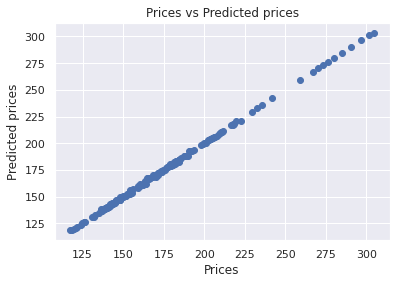

In [ ]:
 # Visualizing the differences between actual prices and predicted values
plt.scatter(y_train, y_pred)
plt.xlabel("Prices")
plt.ylabel("Predicted prices")
plt.title("Prices vs Predicted prices")
plt.show()

In [ ]:
#Predicting Test data with the model
y_test_pred = reg2.predict(x_test)
y_test_pred

array([126.06007, 144.67323, 177.19804, 122.68726, 187.67244, 158.87302,
       176.26897, 180.7735 , 181.7751 , 177.92154, 211.68034, 176.4876 ,
       146.92183, 155.07722, 155.61636, 193.27443, 167.07286, 266.74005,
       160.69983, 172.79468, 151.2528 , 147.19453, 142.04039, 178.9101 ,
       210.38873, 182.52039, 242.21248, 130.43193, 166.65572, 132.1802 ,
       242.21248, 168.73215, 151.34517, 147.71051, 211.68034, 161.96178,
       140.59782, 119.45892, 132.63344, 152.8762 , 136.81311, 152.88254,
       172.66084, 174.9138 , 167.93822, 167.56514, 198.24208, 175.54916,
       220.46939, 259.15695, 170.48717, 142.11139, 205.4281 , 205.9056 ,
       219.90869, 227.47142, 155.47443, 137.80887, 158.15253, 146.54462,
       149.31885, 141.60948, 193.1166 , 162.11423, 204.12915, 236.9661 ,
       142.31255, 130.39471, 142.83032, 167.40642, 143.07013, 168.5803 ,
       140.63954, 184.27841], dtype=float32)

In [ ]:
# Model Evaluation
acc_xgb = metrics.r2_score(y_test, y_test_pred)
print('R^2:', acc_xgb)
print('Adjusted R^2:',1 - (1-metrics.r2_score(y_test, y_test_pred))*(len(y_test)-1)/(len(y_test)-x_test.shape[1]-1))
print('MAE:',metrics.mean_absolute_error(y_test, y_test_pred))
print('MSE:',metrics.mean_squared_error(y_test, y_test_pred))
print('RMSE:',np.sqrt(metrics.mean_squared_error(y_test, y_test_pred)))

R^2: 0.9937804743241525
Adjusted R^2: 0.9925569610764448
MAE: 2.0493798201277436
MSE: 6.679720639112542
RMSE: 2.5845155521127245


In [ ]:
reg2.score(x_train,y_train)

0.9995813355889346

In [ ]:
reg2.score(x_test,y_test)

0.9937804743241525

In [ ]:
models = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest', 'XGBoost'],
    'R-squared Score': [acc_linreg*100, acc_rf*100, acc_xgb*100]})
models.sort_values(by='R-squared Score', ascending=False)

,Model,R-squared Score
0,Linear Regression,99.829950
1,Random Forest,99.589501
2,XGBoost,99.378047


From the above table we can infer that linear regression gives the highest R-square score.

In [ ]:
feature_cols = x.columns.tolist()

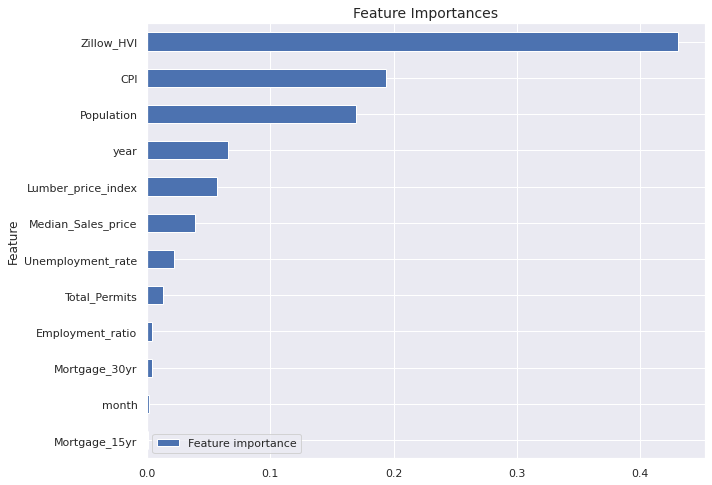

In [ ]:
# Plot feature importance of selected model - Random Forest
fea_df = pd.DataFrame({'Feature':feature_cols, 'Feature importance':reg.feature_importances_})
fea_df = fea_df.sort_values(by='Feature importance')

fig, ax = plt.subplots(figsize=(10,8))
fea_df.plot.barh(x='Feature', y='Feature importance', ax=ax)
plt.title('Feature Importances', fontsize=14);

For Randomn forest, Zillow_HVI and CPI have a significant impact.

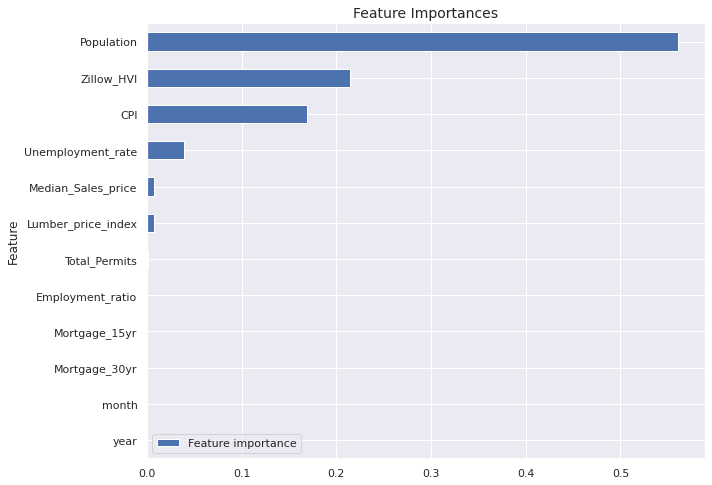

In [ ]:
# Plot feature importance of selected model - XGB
fea_df = pd.DataFrame({'Feature':feature_cols, 'Feature importance':reg2.feature_importances_})
fea_df = fea_df.sort_values(by='Feature importance')

fig, ax = plt.subplots(figsize=(10,8))
fea_df.plot.barh(x='Feature', y='Feature importance', ax=ax)
plt.title('Feature Importances', fontsize=14);

For XGB Population and Zillow_HVI have the highest impact.


We can conclude that Zillow_HVI and CPI plays the major role in predicting HPI.

# Using Auto_TS for timeseries forecasting.

In [ ]:
# !pip install pycaret-ts-alpha

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from pycaret.datasets import get_data
data = HPI_target

In [ ]:
data.set_index('date' ,inplace = True)

<AxesSubplot:xlabel='date'>

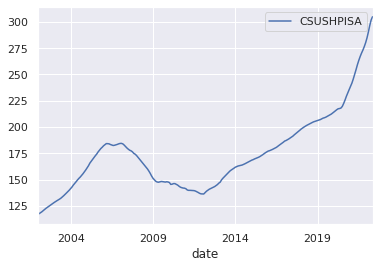

In [ ]:
data.plot()

In [ ]:
from pycaret.time_series import *
s = setup(data, session_id = 123)

INFO:logs:PyCaret TSForecastingExperiment
INFO:logs:Logging name: ts-default-name
INFO:logs:ML Usecase: MLUsecase.TIME_SERIES
INFO:logs:version 3.0.0
INFO:logs:Initializing setup()
INFO:logs:self.USI: e1c6
INFO:logs:self.variable_keys: {'y_train_transformed', 'y_test', 'fh', 'y', 'exogenous_present', 'exp_name_log', 'html_param', '_all_models', 'USI', 'gpu_param', '_all_metrics', '_all_models_internal', '_gpu_n_jobs_param', 'seasonal_period', 'enforce_pi', 'logging_param', 'X', 'fold_generator', 'experiment__', 'fold_param', 'exp_id', 'display_container', 'master_model_container', 'data', 'idx', 'n_jobs_param', 'enforce_exogenous', 'all_sp_values', 'y_transformed', 'X_train_transformed', 'fold_groups_param_full', 'primary_sp_to_use', 'log_plots_param', 'variable_keys', 'X_transformed', '_ml_usecase', 'index_type', 'y_train', 'X_test_transformed', 'seasonality_present', 'memory', 'X_train', 'seed', '_available_plots', 'X_test', 'approach_type', 'y_test_transformed', 'strictly_positive',

,Description,Value
0,session_id,123
1,Target,CSUSHPISA
2,Approach,Univariate
3,Exogenous Variables,Not Present
4,Data shape,"(245, 1)"
5,Train data shape,"(244, 1)"
6,Test data shape,"(1, 1)"
7,Fold Generator,ExpandingWindowSplitter
8,Fold Number,3
9,Enforce Prediction Interval,False


INFO:logs:setup() successfully completed in 0.28s...............


In [ ]:
check_stats()

,Test,Test Name,Data,Property,Setting,Value
0,Summary,Statistics,Actual,Length,,245.0
1,Summary,Statistics,Actual,Mean,,174.376616
2,Summary,Statistics,Actual,Median,,169.138
3,Summary,Statistics,Actual,Standard Deviation,,37.189074
4,Summary,Statistics,Actual,Variance,,1383.027191
5,Summary,Statistics,Actual,Kurtosis,,1.629566
6,Summary,Statistics,Actual,Skewness,,1.203938
7,Summary,Statistics,Actual,# Distinct Values,,245.0
8,White Noise,Ljung-Box,Actual,Test Statictic,"{'alpha': 0.05, 'K': 24}",2865.845315
9,White Noise,Ljung-Box,Actual,Test Statictic,"{'alpha': 0.05, 'K': 48}",3269.310986


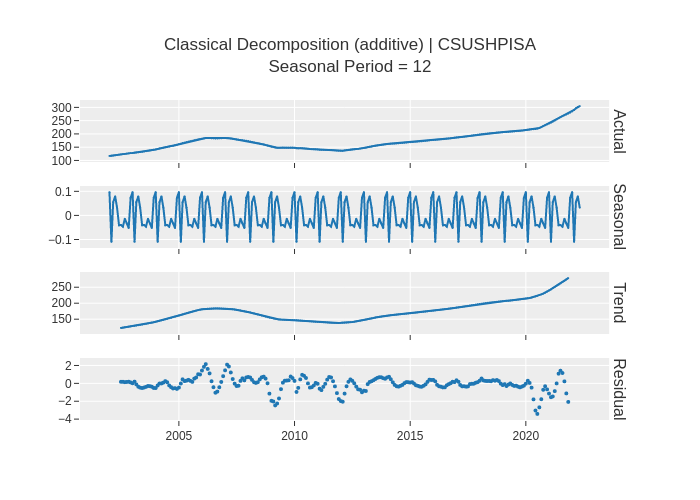

INFO:logs:Visual Rendered Successfully


In [ ]:
plot_model(plot = 'decomp_classical')

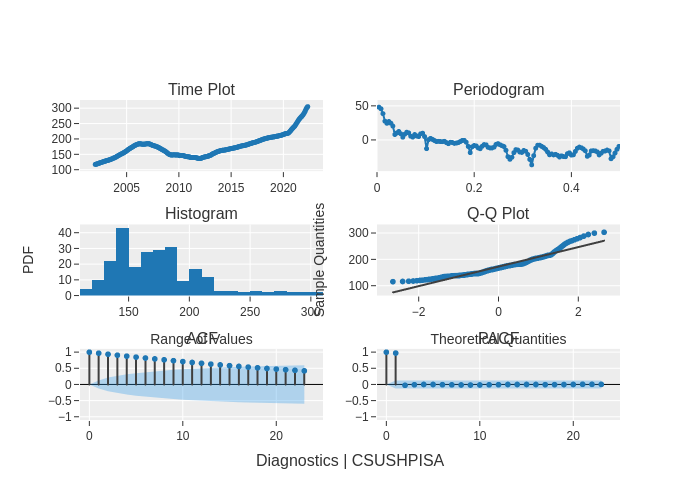

INFO:logs:Visual Rendered Successfully


In [ ]:
plot_model(plot = 'diagnostics')

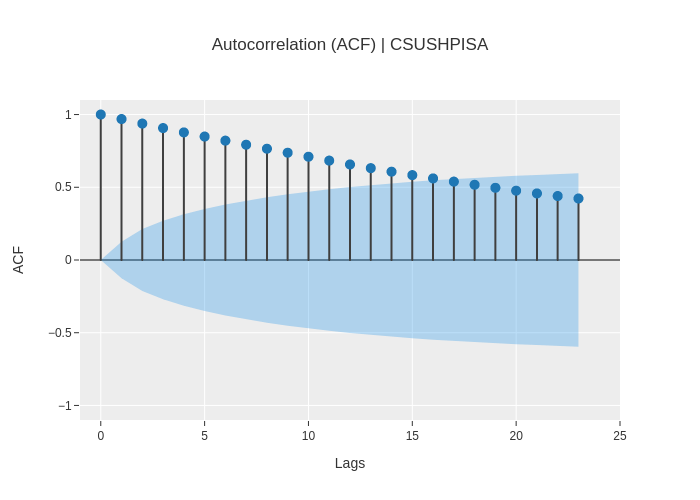

INFO:logs:Visual Rendered Successfully


In [ ]:
plot_model(plot = 'acf')

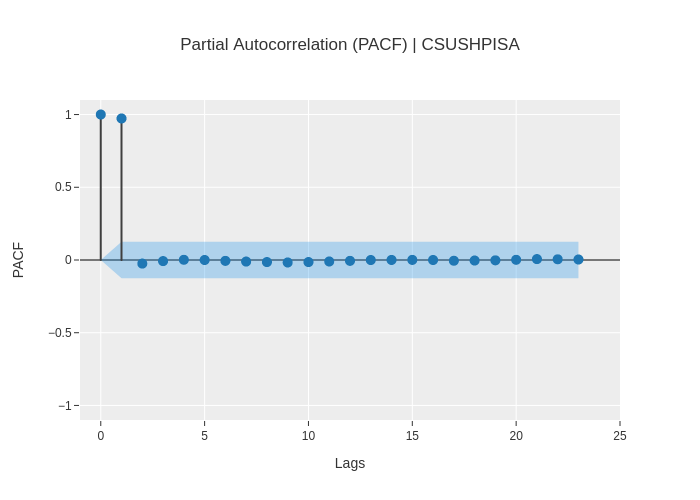

INFO:logs:Visual Rendered Successfully


In [ ]:
plot_model(plot = 'pacf')

In [ ]:
best = compare_models()

,Model,MAE,RMSE,MAPE,SMAPE,MASE,RMSSE,TT (Sec)
auto_arima,Auto ARIMA,0.606,0.606,0.002,0.002,0.0491,0.0399,21.9400
br_cds_dt,Bayesian Ridge w/ Cond. Deseasonalize & Detren...,0.5781,0.5781,0.002,0.002,0.0471,0.0383,0.0367
lr_cds_dt,Linear w/ Cond. Deseasonalize & Detrending,0.5749,0.5749,0.002,0.002,0.0468,0.0381,0.0633
ridge_cds_dt,Ridge w/ Cond. Deseasonalize & Detrending,0.6576,0.6576,0.0022,0.0022,0.0535,0.0436,0.0367
huber_cds_dt,Huber w/ Cond. Deseasonalize & Detrending,0.6874,0.6874,0.0023,0.0023,0.0558,0.0454,0.0533
ets,ETS,0.6937,0.6937,0.0024,0.0024,0.0565,0.046,0.3833
exp_smooth,Exponential Smoothing,0.6952,0.6952,0.0024,0.0024,0.0566,0.0461,0.5867
arima,ARIMA,1.9072,1.9072,0.0065,0.0065,0.1551,0.1263,0.2700
lasso_cds_dt,Lasso w/ Cond. Deseasonalize & Detrending,2.0272,2.0272,0.0069,0.0069,0.1646,0.1339,0.0367
en_cds_dt,Elastic Net w/ Cond. Deseasonalize & Detrending,2.2203,2.2203,0.0075,0.0075,0.1802,0.1466,0.0400


INFO:logs:master_model_container: 27
INFO:logs:display_container: 2
INFO:logs:AutoARIMA(random_state=123, sp=12, suppress_warnings=True)
INFO:logs:compare_models() successfully completed......................................


In [ ]:
best

AutoARIMA(random_state=123, sp=12, suppress_warnings=True)

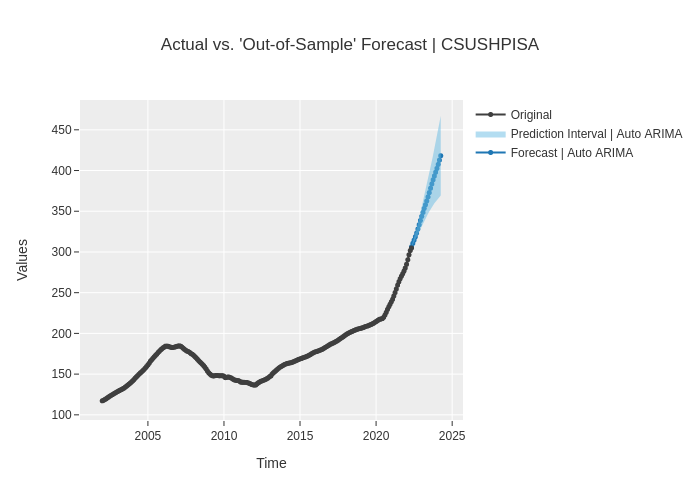

INFO:logs:Visual Rendered Successfully


In [ ]:
plot_model(best, plot = 'forecast', data_kwargs = {'fh': 24})

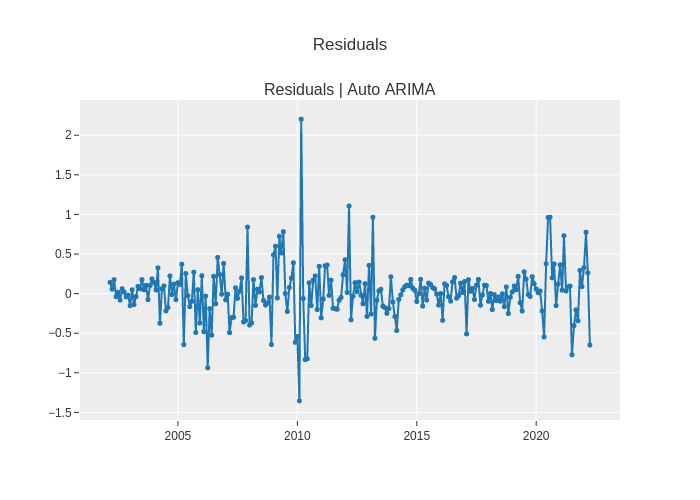

INFO:logs:Visual Rendered Successfully


In [ ]:
plot_model(best, plot = 'residuals')

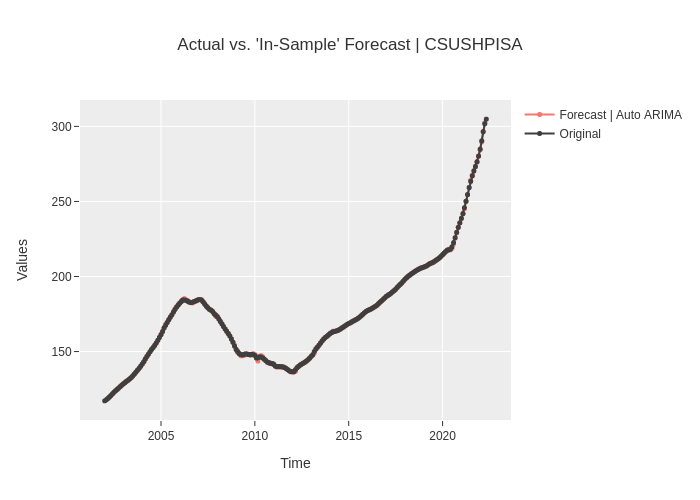

INFO:logs:Visual Rendered Successfully


In [ ]:
plot_model(best, plot = 'insample')

In [ ]:
final_best = finalize_model(best)

INFO:logs:Initializing finalize_model()
INFO:logs:finalize_model(self=<pycaret.time_series.forecasting.oop.TSForecastingExperiment object at 0x7fcc866fd410>, estimator=AutoARIMA(random_state=123, sp=12, suppress_warnings=True), fit_kwargs=None, groups=None, model_only=True, experiment_custom_tags=None, display=None)
INFO:logs:Finalizing AutoARIMA(random_state=123, sp=12, suppress_warnings=True)
INFO:logs:Initializing create_model()
INFO:logs:create_model(self=<pycaret.time_series.forecasting.oop.TSForecastingExperiment object at 0x7fcc866fd410>, estimator=AutoARIMA(random_state=123, sp=12, suppress_warnings=True), fold=None, round=4, cross_validation=True, predict=True, fit_kwargs={}, groups=None, refit=True, probability_threshold=None, experiment_custom_tags=None, verbose=False, system=False, add_to_model_list=False, metrics=None, display=None, kwargs={})
INFO:logs:Checking exceptions
INFO:logs:Importing libraries
INFO:logs:Copying training dataset
INFO:logs:Defining folds
INFO:logs:D

In [ ]:
save_model(final_best, 'my_best_model')

INFO:logs:Initializing save_model()
INFO:logs:save_model(model=AutoARIMA(random_state=123, sp=12, suppress_warnings=True), model_name=my_best_model, prep_pipe_=None, verbose=True, use_case=MLUsecase.TIME_SERIES, kwargs={})
INFO:logs:Adding model into prep_pipe
INFO:logs:my_best_model.pkl saved in current working directory
INFO:logs:AutoARIMA(random_state=123, sp=12, suppress_warnings=True)
INFO:logs:save_model() successfully completed......................................


Transformation Pipeline and Model Successfully Saved


(AutoARIMA(random_state=123, sp=12, suppress_warnings=True),
 'my_best_model.pkl')

In [ ]:
loaded_model = load_model('my_best_model')

INFO:logs:Initializing load_model()
INFO:logs:load_model(model_name=my_best_model, platform=None, authentication=None, verbose=True)


Transformation Pipeline and Model Successfully Loaded


In [ ]:
from datetime import datetime
from dateutil import relativedelta
now = datetime.now()

# convert to string
# get two dates
d1 = now.strftime("%d/%m/%Y")
d2 = input("enter date in dd/mm/yyyy format")

# convert string to date object
start_date = datetime.strptime(d1, "%d/%m/%Y")
end_date = datetime.strptime(d2, "%d/%m/%Y")

# Get the relativedelta between two dates
delta = relativedelta.relativedelta(end_date, start_date)
# print(delta.months)
# print(delta.years)
target_month=delta.months+(12*delta.years)

enter date in dd/mm/yyyy format03/09/2023


In [ ]:
pred = predict_model(loaded_model, fh = target_month)
pred

,y_pred
2022-06,307.2574
2022-07,309.4574
2022-08,312.1616
2022-09,315.6605
2022-10,319.9389
2022-11,324.6871
2022-12,329.3292
2023-01,333.5076
2023-02,337.1534
2023-03,340.4960


<AxesSubplot:>

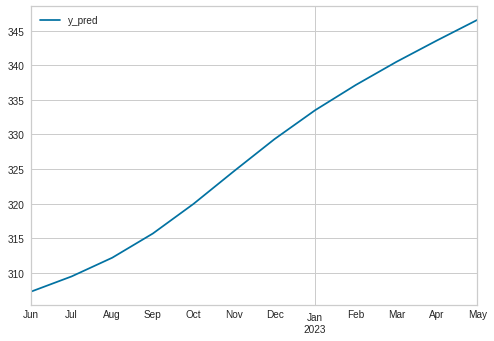

In [ ]:
pred.plot()

# Conclusion:


From the above data analysis and modeling i would like to share some key insights.
1. To predict House price Index key factors are Zillow House value index and Consumer price index.
2. Some other key factors are lumber and wood price index and median sale price.

Future aspects:
>1.Expansion of the above projects will be deploying the model with parameter tuning to predict the house price index at specified time.


>2.Using Time-series forecast models we can continue to fine tune the model and forecast HPI as per needs.
